<table style="width: 100%;">
  <tr>
    <td style="text-align: left;"><h1 style="font-size: 30px;">Review of dataset</h1></td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>

# Data Analysis - Second Iteration - Summary

In this second iteration of our data analysis, our primary focus is to improve the performance of the Random Forest model that we previously developed. To achieve this, we will explore various aspects of our data and model. Here are the main areas we will be investigating:

## Areas of Focus

1. **Review Count Thresholds to train the RF** In previouse iterations I chose at random that I would only use accomodations with at least 100 reviews to improve consistency. Now I want to see if I can bring down this number in the spirit of having more training data without compromising the value of the data.

2. **Utilizing Full Location Variable:** We will consider the full location variable to assess whether it provides more valuable information for our model compared to a simplified or reduced representation.

3. **Incorporating Full Amenities Variables:** Instead of using Principal Component Analysis (PCA) on amenities, we will use the full amenities variables to evaluate if this leads to better model performance.

5. **Sentiment Analysis:** We will incorporate sentiment analysis of reviews as a feature to gauge its impact on the model's performance.

6. **GPT analysis** We will be performing prompt engeniering to extract better features from description. We will be using a package that allows us to use GPT without paying.

7. **Location Score Analysis:** We will delve deeper into the impact of location on our predictions. This includes examining how different location variables affect the model's performance.

8. **Outliar Analysis:** We will look into the values where the score is particularly low.

Additionally, we will create custom transformers to make the data processing process more seamless. These custom transformers will assist in efficiently preparing the data for model training and analysis.

Through these investigations, we aim to fine-tune our Random Forest model and improve its predictive accuracy. By considering a more detailed representation of location, amenities, and reviews, we expect to uncover valuable insights that will lead to better results.

Let's begin our exploration and analysis, making use of custom transformers to enhance our data processing workflow and streamline our efforts in enhancing our model's performance.

## Imports and database initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import re 
import seaborn as sns
from scipy import stats

# Eliminate warnings for presentation purpuses
import warnings
warnings.filterwarnings('ignore') #ignore all warnings, very messy
#warnings.filterwarnings('default')
pd.options.mode.chained_assignment = None
from rich import print

#preatty printing
from rich import print
from tabulate import tabulate
from IPython.display import Markdown
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', 100)
from prettytable import PrettyTable
import icecream as ic
import os

import shap
from sklearn.model_selection  import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
insights = pd.read_csv('bdd_barcelona/insight_with_sentiment.csv')
reviews = pd.read_csv('bdd_barcelona/reviews.csv')

In [3]:
def filter_accomodation_num_review(bdd, col_name, min_reviews = 100):
    return bdd[bdd[col_name] >= min_reviews]

In [4]:
filtered_insights_50 = filter_accomodation_num_review(insights, 'number_of_reviews', 20)
filtered_insights_100 = filter_accomodation_num_review(insights, 'number_of_reviews', 100)
print(f"When filtering for accomodations with at least 100 reviews, we get {len(filtered_insights_100)} distinct accomodations")
print(f"When filtering for accomodations with at least 50 reviews, we get {len(filtered_insights_50)} distinct accomodations")

When filtering for accomodations with at least 100 reviews, we get 2320 distinct accomodations

When filtering for accomodations with at least 50 reviews, we get 6188 distinct accomodations

In [5]:
display(filtered_insights_50.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

# Model

## Transformer and model

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# function to only do the 1HOTEncoder in neighbourhood
def encode_neighbourhood(bdd):
    nei_list = ['neighbourhood_group_cleansed','neighbourhood_cleansed']

    # Tranformer
    nei_pipeline = ColumnTransformer([
        ('nei',OneHotEncoder(), nei_list),
    ])

    nei_pipeline.fit(bdd)
    nei_HOT = pd.DataFrame(nei_pipeline.transform(bdd).toarray(), columns = nei_pipeline.get_feature_names_out())
    #print(nei_pipeline.feature_names_in_)
    return pd.concat([bdd, nei_HOT], axis=1)

In [7]:
import pandas as pd
import re
import ast
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import icecream as ic


#-------------------------------------------- CUSTOM TRANSFORMER AMENITIES ---------------------------------------
#-----------------------------------------------------------------------------------------------------------------

class AmenitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encode_dict = {}             # This contains the dictionary of transformations
        self.filtered_amenities_list = [] # This contains the list of unique features ONEHOTENCODED

    def fit(self, X, y=None):
        all_amenities = []

        # Extract and preprocess amenities
        for sublist in X['amenities']:
            real_sublist = ast.literal_eval(sublist)
            for word in real_sublist:
                all_amenities.append(word)

        unique_amenities_list = sorted(set(all_amenities))

        # Compress specific amenities
        patterns_to_compress = [
            ('TV', 'TV'), ('shampoo', 'shampoo'), ('soap', 'soap'), ('parking', 'parking', 'garage'),
            ('exercise', 'gym'), ('stove', 'stove'), ('oven', 'oven'), ('coffee', 'coffee'), ('refrigerator', 'refrigerator'),
            ('books', 'books'), ('pool', 'pool'), ('clothing', 'clothing'), ('Washer', 'washer'), ('conditioner', 'conditioner'),
            ('dryer', 'dryer'), ('backyard', 'backyard'), ('Baby', 'Baby'), ('console', 'console'), ('sound', 'sound'),  
            ('grill', 'grill'), ('fireplace', 'fireplace'), ('Shared hot tub', 'Shared hot tub'), ('hot tub', 'hot tub'), 
            ('beach', 'beach'), ('chair', 'chair'), ('crib', 'crib')
        ]
        self.compress_amenities(unique_amenities_list, 'wifi', 'wifi')
        for pattern in patterns_to_compress:
            label, *patterns = pattern
            self.compress_amenities(self.filtered_amenities_list, label, *patterns)
    
        return self

    def transform(self, X):
        filtered_insight_OHE_2 = X.copy()
        filtered_insight_OHE_2['amenities'] = filtered_insight_OHE_2['amenities'].apply(ast.literal_eval)

        for value in self.filtered_amenities_list:
            appear = False
            if value in self.encode_dict.keys():
                word_filter = self.encode_dict[value]
            else:
                word_filter = [value]
            filtered_insight_OHE_2[value] = filtered_insight_OHE_2.apply(lambda row: 1.0 if self.check_amenities_in_filter(row['amenities'], word_filter) else 0.0, axis=1)

        return filtered_insight_OHE_2

    def compress_amenities(self, amenities_list, label, *patterns):
        pattern = re.compile('|'.join(patterns), re.IGNORECASE)
        var_list = [word for word in amenities_list if pattern.search(word)]
        self.filtered_amenities_list = [amenity for amenity in amenities_list if not pattern.search(amenity)]
        self.filtered_amenities_list.append(label)
        self.encode_dict[label] = var_list

    def check_amenities_in_filter(self, amenities, filter):
        return any(amenity in filter for amenity in amenities)
    def get_feature_names_out(self):
        return self.filtered_amenities_list

# Usage:
#amenities_transformer = AmenitiesTransformer()
#filtered_insight_transformed = amenities_transformer.fit_transform(A)
#features = amenities_transformer.get_feature_names_out()
#print(filtered_insight_transformed)

In [8]:
def describe_dataframe(df):
    # Create an empty list to store the result data
    result_data = []

    # Iterate through the columns of the input DataFrame
    for column_name in df.columns:
        data_type = df[column_name].dtypes  # Get the data type of the column
        example_value = df[column_name].iloc[0]  # Get the first value in the column

        # Append the information as a dictionary to the result list
        result_data.append({'Variable': column_name, 'Data Type': data_type, 'Example Value': example_value})

    # Convert the result list to a DataFrame
    result_df = pd.DataFrame(result_data)

    # Convert the result DataFrame to an HTML table
    html_table = result_df.to_html(classes='table table-striped table-hover', escape=False, index=False)

    display(HTML(html_table))

In [9]:
#---------------------------------------------------------------------------------------------------------
#-------------------------------------------- MAKE ALL TRANSFORMATIONS TO THE DATABASE -------------------
#---------------------------------------------------------------------------------------------------------
def transform_bdd_2(bdd,aditional_num_variables = [], aditional_other_variables = []):
    
    bdd = bdd.dropna(subset=['id'])
    # 3---------------------------------------DROP COLUMNS-----------------------------------------------------
    col_names = ["Unnamed: 0.1","Unnamed: 0","listing_url","scrape_id","last_scraped","source","name"
                ,"picture_url","host_id","host_url","host_name","host_since",
                "host_location","host_about","host_response_time","host_response_rate","host_acceptance_rate",
                "host_thumbnail_url","host_picture_url","host_neighbourhood","host_verifications","instant_bookable",
                "neighbourhood","neighborhood_overview","name","has_availability","calendar_last_scraped",'latitude','longitude']

    columns_to_drop = [col for col in col_names if col in bdd.columns]
    bdd.drop(columns=columns_to_drop, inplace=True)
    # 4------------------------------------FORMATTING BOOLEAN CLUMNS-------------------------------------------------------
    replacement_dict = {"f": 0.0, "t": 1.0}
    columns_to_replace = ["host_is_superhost","host_has_profile_pic","host_identity_verified"]
    bdd[columns_to_replace] = bdd[columns_to_replace].replace(replacement_dict)
    # 5------------------------------------FORMATTING PRICE----------------------------------------------
    try:
        bdd["price"] = bdd["price"].apply(lambda x: float(x.replace("$", "").replace(",", "")))
    except (AttributeError, ValueError) as e:
        print("Price already transformed to float")
        
    # 6-----------------------------------FORMAT DATES--------------------------------------------------
    date_features = ['first_review','last_review']
    #print(f"first: {'first_review' in bdd.columns}  last: {'last_review' in bdd.columns}")
    for col in date_features:
        try:
            #bdd[col] = pd.to_datetime(bdd[col], format="%Y-%m-%d")
            bdd[col] = pd.to_datetime(bdd[col], format="%m/%d/%Y")
            bdd[col] = (bdd[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
            #print(bdd[col].dtypes)
        except (ValueError, TypeError) as e:
            print("Date already tranformed")

    # 7-----------------------------------FORMAT bathrooms_text--------------------------------------------------

    bdd["bathrooms"] = bdd["bathrooms_text"].str.extract(r'(\d+(\.\d+)?)', expand=False)[0].astype(float)
    bdd.drop('bathrooms_text', axis=1, inplace=True)

    # 8---------------------------------BOOLS------------------------------------------------------------------
    bdd["has_license"] = np.where(bdd["license"].notnull(), 1, 0)

    
    
    # 7-----------------------------------Tranformer-------------------------------------------------------------
    hot_features = ['neighbourhood_group_cleansed','neighbourhood_cleansed',"property_type","room_type"]
    num_features = ['host_listings_count','host_total_listings_count','host_has_profile_pic','host_identity_verified',
    'accommodates','bedrooms','beds','price','minimum_nights','maximum_nights',
    'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm','availability_30','availability_60','availability_90','availability_365','number_of_reviews',
    'number_of_reviews_ltm','number_of_reviews_l30d','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','first_review','last_review',"size"]
    
    other_features = ['host_is_superhost', 'calendar_updated','amenities','id','sentiment','sent1','sent2','sent3','sent4','sent5','sent6','sent7','sent8','sent9','sent10',]   
    other_features = ['host_is_superhost', 'calendar_updated','amenities','id','sentiment'] 
    other_features = ['host_is_superhost','amenities','id','sentiment',"capacity","alowed_under_25","family_friendly","bathrooms","has_license"] 
    if 'sentiment' not in list(bdd.columns):
        bdd = bdd.assign(sentiment=0)
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler',StandardScaler())        
    ])
    
    def identity(df):
        return df
    iden = FunctionTransformer(identity)
    
    pipe = ColumnTransformer([
        ('1HOT',OneHotEncoder(), hot_features),
        ('numbers',num_pipeline, num_features),
        ('identity',iden, other_features)
    ],
        sparse_threshold=0 )
    #describe_dataframe(bdd)
    pipe.fit(bdd)
    bdd = pd.DataFrame(pipe.transform(bdd), columns = list(pipe.named_transformers_['1HOT'].get_feature_names_out()) + list(pipe.named_transformers_['numbers'].get_feature_names_out()) + other_features)
    #bdd = pd.concat([bdd, nei_HOT], axis=1)
    bdd = bdd.dropna(subset=['id'])
    
    amenities_transformer = AmenitiesTransformer()
    bdd = amenities_transformer.fit_transform(bdd)
    
    bdd.fillna(0, inplace=True)
    bdd.drop(columns=['id','amenities'], inplace=True)
    return bdd

In [10]:
## --------------------------------------------TEXT EMBEDDING: BERT-------------------------------------------------
## -------------------------------------------USED TO DESCRIBE THE DESCRIPTION--------------------------------------
## Call only if needed, we will do it once and then save the database, after the transformations, we will append the embeded description
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

def calculate_embedings(bdd,column_to_embed):
    # Load the pre-trained BERT model and tokenizer (you need to install transformers)
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    text_column = bdd[column_to_embed]

    # Initialize an empty list to store the embeddings
    embeddings = []

    # Loop through each element in the column and embed it
    for text in text_column:
        # Tokenize and convert the sentence to input format
        #print(type(text))
        if type(text)==float:
            text = ""
        if text == np.nan:
            text = ""
        tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

        # Get the sentence embedding
        with torch.no_grad():
            outputs = model(**tokens)
            sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

        # Append the embedding to the list
        embeddings.append(sentence_embedding)

    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)

    # train and fit the PCA for description embeded
    embeddings_array_t = embeddings_array

    variance = 0.95 

    emb = embeddings_array_t.copy()

    pca_description = PCA(n_components = variance)
    compressed = pca_description.fit_transform(emb)

    compressed = compressed.T

    print(f"Amound of components from using BERT embedding: {len(embeddings_array_t.T)}")
    print(f"Amound of components from using BERT embedding and using a PCA: {len(compressed)}")


    description_EMB_PCA = pd.DataFrame()
    description_EMB = pd.DataFrame()

    column_titles = [f'{column_to_embed}_{i}' for i in range(len(compressed))]
    for i in range(len(compressed)):
        description_EMB_PCA[column_titles[i]] = compressed[i]

    column_titles = [f'{column_to_embed}_{i}' for i in range(len(embeddings_array_t.T))]
    for i in range(len(embeddings_array_t.T)):
        description_EMB[column_titles[i]] = embeddings_array_t.T[i]

    #display(final_bdd_PCA.shape)
    #display(final_bdd.shape)
    
    #Save the embedings because it is costrly to run this function
    description_EMB_PCA.to_csv(f'{column_to_embed}_EMB_PCA.csv', index=False)
    description_EMB.to_csv(f'{column_to_embed}_EMB.csv', index=False)
    
    return (description_EMB_PCA,description_EMB)

In [11]:
import os

def load_description_embeddings(bdd,column_to_embed):

    document_name_PCA = f'{column_to_embed}_EMB_PCA.csv'
    document_name = f'{column_to_embed}_EMB.csv'
    # Check if the document exists in the folder
    if os.path.exists( document_name_PCA) :
        print(f"Loading {column_to_embed} Embeddings")
        description_EMB_PCA = pd.read_csv(document_name_PCA)
        description_EMB = pd.read_csv(document_name)
        print('Loaded')

    else:
        print(f"Calculating Full {column_to_embed} Embeddings")
        description_EMB_PCA, description_EMB = calculate_embedings(bdd,column_to_embed)
        print("Calculated")
    try:
        columns_to_drop = [col for col in [{column_to_embed}] if col in bdd.columns] # per seguretat
        bdd.drop(columns=columns_to_drop, inplace=True)
    except:
        pass
    return (description_EMB_PCA,description_EMB)


In [12]:
def bdd_premodel(df,directory = "AB/normal",case = 0, recalculate = False): 
    outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
    print("-----------------------------PREMODEL: START -------------------------")
    doc_name_A = f"{directory}/A.csv"
    doc_name_B = f"{directory}/B.csv"
    # Check if the document exists in the folder
    if os.path.exists(doc_name_A) & (not recalculate):
        print("-----------------------------PREMODEL: Already calculated -------------------------")
        A = pd.read_csv(doc_name_A)
        B = pd.read_csv(doc_name_B)
        print("-----------------------------PREMODEL: LOADED -------------------------")
    else:
        print("-----------------------------PREMODEL: Not found, satrt calculations -------------------------")
        A = df.drop(columns=outpus_types, axis=1)
        B = df[outpus_types].copy()
        print(f"Shape of A before transforming: {A.shape}")
        A = transform_bdd_2(A)
        # Cal comprovar si és millor amb o sense descriptió
        if case == 1:
            description_EMB_PCA,description_EMB = load_description_embeddings(A,'description')
            A = pd.concat([A, description_EMB_PCA], axis=1)
        # Cal comprovar si és millor amb o sense nei_overview
        if case == 2:
            description_EMB_PCA,description_EMB = load_description_embeddings(A,'neighborhood_overview')
            A = pd.concat([A, description_EMB_PCA], axis=1)
        if case == 3:
            description_EMB_PCA,description_EMB = load_description_embeddings(A,'description')
            A = pd.concat([A, description_EMB_PCA], axis=1)
            description_EMB_PCA,description_EMB = load_description_embeddings(A,'neighborhood_overview')
            A = pd.concat([A, description_EMB_PCA], axis=1)
        print(f"Shape of A after full transforming: {A.shape}")
        print("Now the database A is ready to be used")
        print("---------------------------PREMODEL: FINISH ---------------------------")
        
        if not os.path.exists(directory):
            os.makedirs(directory)
        A.to_csv(doc_name_A, index = False)
        B.to_csv(doc_name_B, index = False)
    
    return (A,B)

In [13]:
#A.to_csv("AB/normal/A.csv", index = False)
#B.to_csv("AB/normal/B.csv", index = False)

In [14]:
#filtered_insights_25 = filter_accomodation_num_review(insights, 'number_of_reviews', 25)
filtered_insights_25 = pd.read_csv(f"bdd_barcelona/GPT/filtered_insights_25_senti_GPT.csv")
A,B = bdd_premodel(filtered_insights_25)
#results_df = model_testing(A,B,25) 
#display(results_df)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

## Model Making

In [14]:
import pickle
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def show_pretty_r2_table(test,pred,min_reviews,results_df = None):
    table = PrettyTable()
    table.field_names = ["Model", "Score type", "R^2", "MSE"]
    try:
        if results_df is None:
            results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
    except Exception as e:
        pass
    rows_to_append = []
    total_r2_score = 0
    for i in range(7):
        mse = mean_squared_error(test.values.T[i], pred.T[i])
        r2 = r2_score(test.values.T[i], pred.T[i])
        table.add_row([f"RF >{min_reviews}revi", test.columns[i], f"{r2:.4f}", f"{mse:.4f}"])
        rows_to_append.append({"Model": f"RF >{min_reviews}revi",
                               "Score type": test.columns[i],
                               "R^2": r2,
                               "MSE": mse})
        total_r2_score += r2
    print(table)
    print(total_r2_score)
    return pd.concat([results_df, pd.DataFrame(rows_to_append)], ignore_index=True, axis = 0)

def model_testing(A,B,name=25,results_df = None,recalculate=False):
    
    directory = fr'models/{name}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f"random_forest_model_{name}.pkl")
    score_type = 'review_scores_location'
    #if results_df == None:
        #results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
    print("-------------- MODEL TRAINING: START ----------------------------")
    A.fillna(A.mean(), inplace=True)
    B.fillna(B.mean(), inplace=True)
    # Split the dataset into training and test sets (e.g., 80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)


    regressor = RandomForestRegressor(n_estimators=100,random_state=0)

    regressor.fit(X_train, y_train)
    
    # Save the trained model to a file
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(regressor, pickle_file)
        
    print("-------------- MODEL TRAINING: FINISH ----------------------------")
    y_pred_rf = regressor.predict(X_test)

    results_df = show_pretty_r2_table(y_test,y_pred_rf,name,results_df)
    results_df.to_csv(fr'models/{name}/results_{name}.csv', index=False)
    return results_df


In [17]:
"""X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
display(y_test.head(1))"""

'X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)\ndisplay(y_test.head(1))'

In [16]:
num_reviews = 25
#filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', num_reviews)
filtered_insights = pd.read_csv(f"bdd_barcelona/GPT/filtered_insights_25_senti_GPT.csv")
A,B = bdd_premodel(filtered_insights)
results_df = model_testing(A,B,num_reviews) 

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >25revi |     review_scores_rating    | 0.5214 | 0.0267 |
| RF >25revi |    review_scores_accuracy   | 0.4756 | 0.0232 |
| RF >25revi |  review_scores_cleanliness  | 0.4025 | 0.0379 |
| RF >25revi |    review_scores_checkin    | 0.6200 | 0.0175 |
| RF >25revi | review_scores_communication | 0.5185 | 0.0184 |
| RF >25revi |    review_scores_location   | 0.3724 | 0.0185 |
| RF >25revi |     review_scores_value     | 0.5250 | 0.0273 |
+------------+-----------------------------+--------+--------+

3.43546172326721

In [18]:
print("Senti and no emb s'ha de guardar")
display(results_df)
display("sentiment" in list(A.columns))

Senti and no emb s'ha de guardar

,Model,Score type,R^2,MSE
0,RF >25revi,review_scores_rating,0.521375,0.026691
1,RF >25revi,review_scores_accuracy,0.475554,0.023217
2,RF >25revi,review_scores_cleanliness,0.402488,0.037914
3,RF >25revi,review_scores_checkin,0.620050,0.017537
4,RF >25revi,review_scores_communication,0.518517,0.018372
5,RF >25revi,review_scores_location,0.372434,0.018494
6,RF >25revi,review_scores_value,0.525044,0.027343


True

## FINDING OUT THE AMOUND OF MINIMUM REVIEWS TO TRAIN THE RF

In [ ]:
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
def find_optimal_min_review(results_df):
    for i in [5,10,15,20,25,30,50,80,100]:
        filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', i)
        A,B = bdd_premodel(filtered_insights)
        results_df = model_testing(A,B,i,results_df) 
    return results_df
results_df = find_optimal_min_review(results_df)
display(results_df)

In [143]:
results_df.to_csv('results_min_rev.csv', index=False)

## MODEL TRAINING

In [20]:
import pickle
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def load_rf_model(filtered_insights, name = 'latest',recalculate = False):
    
    directory = fr'models/{name}'  
    model_path = os.path.join(directory, f'random_forest_model_{name}.pkl')      
           
    # Check if the document exists in the folder
    if os.path.exists(model_path) & (not recalculate):
        print("-----------------------------Model Found-----------------------------")
        with open(model_path, 'rb') as file:
            loaded_model = pickle.load(file)
        A = pd.read_csv(fr'models/{name}/A.csv')
        B = pd.read_csv(fr'models/{name}/B.csv')
        results_df = pd.read_csv(fr'models/{name}/results_{name}.csv')
        print('----------------------------Model Loaded-----------------------------')

    else:
        print("--------------------------Model Not Found----------------------------")
        #filtered_insights = filter_accomodation_num_review(insight_bdd, 'number_of_reviews', min_reviews)
        A,B = bdd_premodel(filtered_insights,f"models/{name}",2,recalculate)
        results_df = model_testing(A,B,name) 
        with open(model_path, 'rb') as file:
            loaded_model = pickle.load(file)
        print("-----------------------------Model Loaded----------------------------")
        
    return (loaded_model,A,B,results_df)

In [21]:
min_reviews = 25
sentiment = True
recalculate = False
filtered_insights = pd.read_csv(f"bdd_barcelona/GPT/filtered_insights_25_senti_GPT.csv")

# Train/load model
model,A,B,results_df = load_rf_model(filtered_insights,"Latest",recalculate)
display(model)

# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

-----------------------------Model Found-----------------------------

----------------------------Model Loaded-----------------------------

RandomForestRegressor(random_state=0)

## RESULT VISUALIZATION

In [22]:
def visualise_outcom(test, pred):
   
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Scatter plot of y_test vs y_pred
    ax1 = axes[0]
    ax1.scatter(test, pred, marker='o', color='blue', alpha=0.5)
    ax1.set_xlabel("True Values (test)")
    ax1.set_ylabel("Predicted Values (pred)")
    ax1.set_title("Scatter Plot of True vs Predicted Values")
    ax1.set_ylim(1, 5)
    ax1.set_xlim(1, 5)

    # Sort the values for a smoother line plot
    sorted_indices = np.argsort(test)
    y_test_sorted = test[sorted_indices]
    y_pred_sorted = pred[sorted_indices]

    # Line plot of y_test vs y_pred
    ax2 = axes[1]
    ax2.plot(range(len(test)), y_test_sorted, label="True Values (test)", marker='o', linestyle='-')
    ax2.plot(range(len(pred)), y_pred_sorted, label="Predicted Values (pred)", marker='x', linestyle='--')
    ax2.set_xlabel("Data Points")
    ax2.set_ylabel("Values")
    ax2.set_title("Line Plot of True vs Predicted Values")
    ax2.legend(loc='upper left')

    # Adjust layout
    plt.tight_layout()

    # Show the combined figure
    plt.show()

review_scores_rating

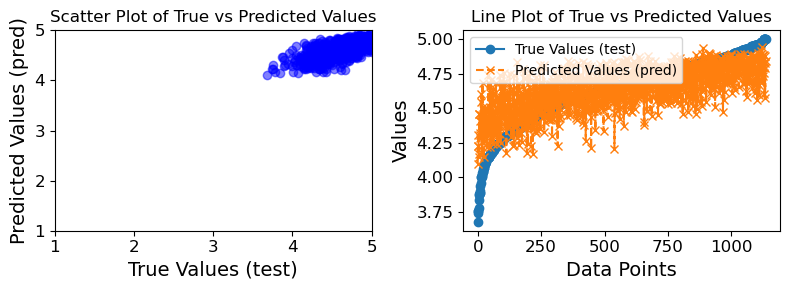

review_scores_accuracy

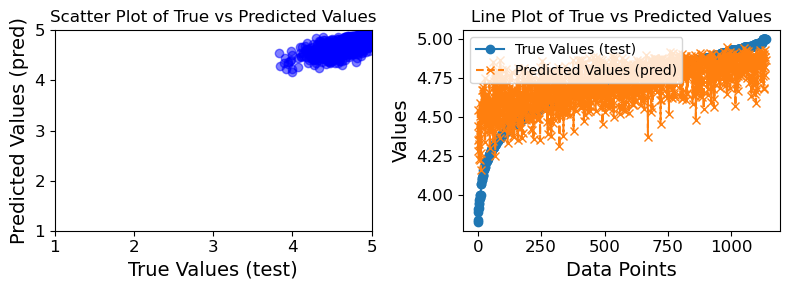

review_scores_cleanliness

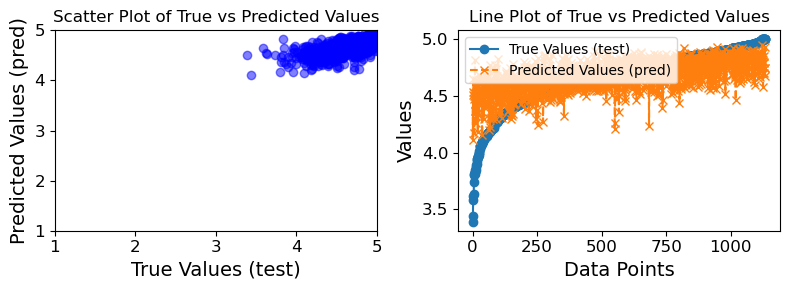

review_scores_checkin

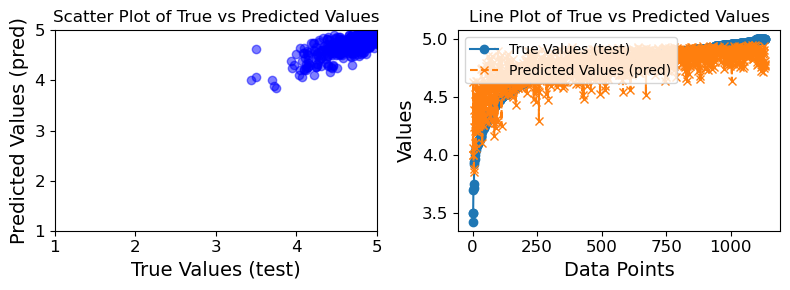

review_scores_communication

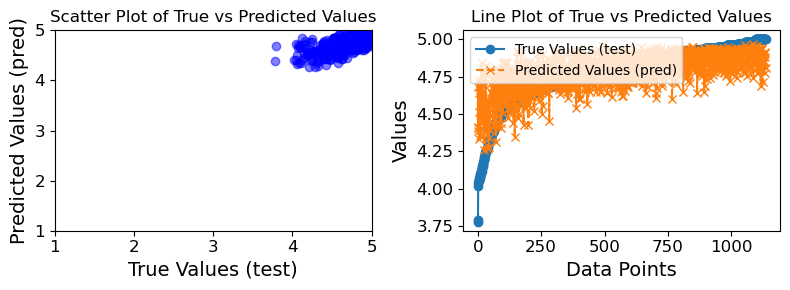

review_scores_location

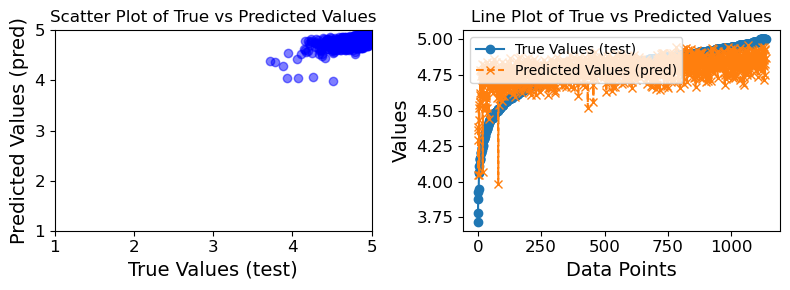

review_scores_value

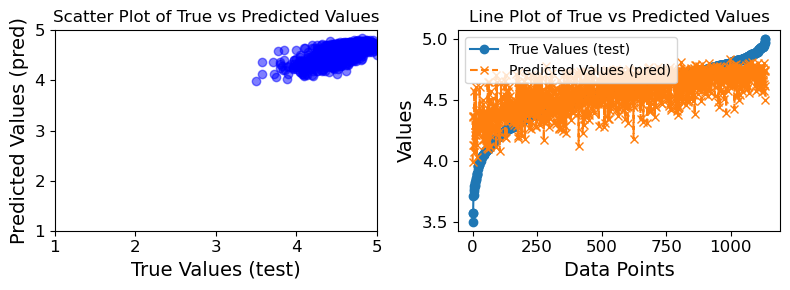

In [23]:
for i in range(7):
    print(f"{y_train.columns[i]}")
    visualise_outcom(y_test.values.T[i], y_pred_rf.T[i])

In [24]:
def reslduals(y_test,y_pred,index):
    # Calculate the residuals
    residuals = y_test - y_pred

    # Create a figure with two subplots: residual error plot and distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Residual Error Plot
    ax1.scatter(x=y_pred, y=residuals, color='b', marker='o', alpha=0.4, label="y_pred")
    ax1.scatter(x=y_test, y=residuals, color='g', marker='o', alpha=0.4, label = "y_test")
    ax1.set_title("Residual Error Plot")
    ax1.set_xlabel("y Values")
    ax1.set_ylabel("Residuals")
    ax1.axhline(y=0, color='r', linestyle='-')
    ax1.legend()

    # Distribution Plot
    sns.histplot(y_pred.T[index], kde=False, ax=ax2,alpha=0.5, color='g',label='y_pred')
    sns.histplot(y_test.T[index], kde=False, ax=ax2,alpha=0.5, color='b', label='y_test')
    ax2.set_title("Residuals Distribution")
    ax2.set_xlabel("Residuals")
    ax2.legend()

    plt.tight_layout()
    plt.show()

review_scores_cleanliness:Residual plots for Randm Forest

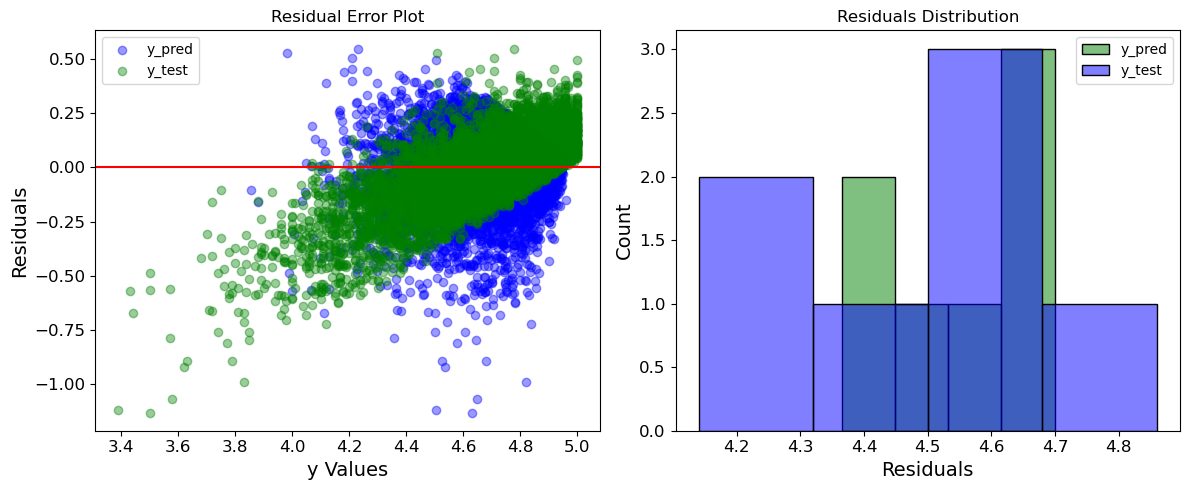

In [29]:
i = 2
print(f"{y_train.columns[i]}:Residual plots for Randm Forest")
reslduals(y_test.values.T,y_pred_rf.T,i)

## EXPLAINABILITY

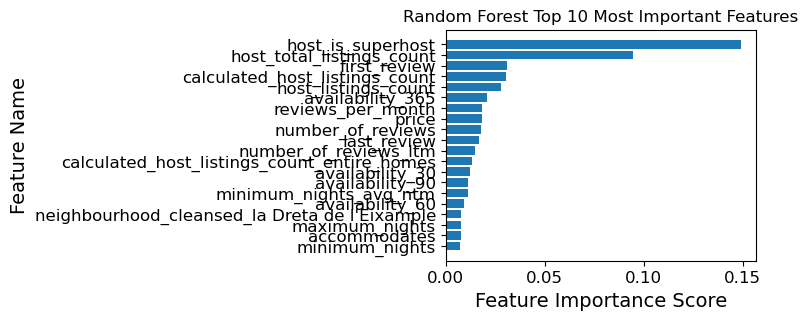

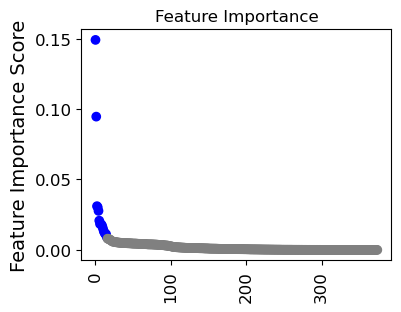

In [30]:
data = {'Name': X_train.columns, 'Score': model.feature_importances_}
df = pd.DataFrame(data)
df = df.sort_values(by='Score', ascending=False)
top_10 = df.head(20)

# Plot a bar chart for the top 10 features
plt.figure(figsize=(4, 3))
plt.barh(top_10['Name'], top_10['Score'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.title('Random Forest Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()

x = [i for i in range(len(df['Score']))]
colors = ['grey' if score < 0.009 else 'blue' for score in df['Score']]
plt.figure(figsize=(4, 3))
plt.scatter(x, df['Score'], c=colors, marker='o')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance')
plt.xticks( rotation=90)  # Set x-axis labels and rotate for better readability
plt.show()

In [21]:
import shap
import pickle
import os
import json
        
def save_results(data,name = "latest",shap = ""):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{name}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, fr'{name}{shap}.json')
    
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)
        
def load_results(name = "latest", shap = ""):
    doc_name = fr'models/{algo}/{name}{shap}.json'
    with open(doc_name, 'rb') as pickle_file:
        results = pickle.load(pickle_file)
    return results

x_sub = shap.sample(X_train,100)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
save_results(shap_values,"latest","_shap")

 12%|==                  | 931/7952 [01:30<11:18]       

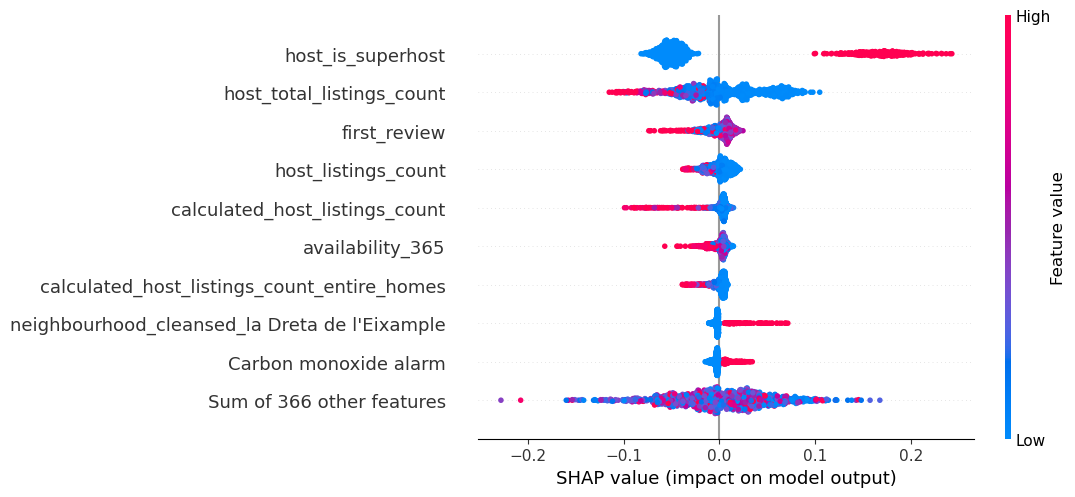

In [56]:
shap.plots.beeswarm(shap_values[:,:,0])

# Feature engeniering

## SENTIMENT ANALYSIS

In [138]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
min_reviews = 25
reviews = pd.read_csv('bdd_barcelona/reviews_with_sentiment.csv')

# Create a new column for sentiment
if 'sentiment' not in list(reviews.columns):
    print("--------------------------------SENTIMENT ANALYSIS: START----------------------------------")
    # Fill the empty comments with "empty"
    reviews["comments"] = reviews["comments"].fillna("empty")
    reviews["sentiment"] = reviews["comments"].apply(lambda review: SentimentIntensityAnalyzer().polarity_scores(review)["compound"])
    print("--------------------------------SENTIMENT ANALYSIS: FINISHED----------------------------------")
    reviews.to_csv("reviews_with_sentiment.csv", index=False)
else:
    print("--------------------------------SENTIMENT ANALYSIS: DONE----------------------------------")

--------------------------------SENTIMENT ANALYSIS: DONE----------------------------------

In [139]:
# Identify the most positive reviews
df_positive = reviews[reviews["sentiment"] > 0.5]

# Identify the most negative reviews
df_negative = reviews[reviews["sentiment"] < -0.5]

# Print the most positive and negative reviews
print("Most positive reviews:")
display(df_positive.iloc[:10, :])

print("Most negative reviews:")
display(df_negative.iloc[:10, :])

Most positive reviews:

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
0,18674,4808211,2013-05-27,4841196,Caron,"Great location. Clean, spacious flat. Would recommend to anyone.",0.8519
2,18674,41087522,2015-08-04,35231385,Shlomi,"Big apartment, well equipped.\r<br/>Very good service, excellent location.\r<br/>Recommended.",0.8271
3,18674,81000756,2016-06-20,23223644,Joost,"The Check in was fast and flexible. The price is fair, because the flat ist big enough for 8 peo...",0.9252
4,18674,278588962,2018-06-18,4756672,Marius,Great location and enough space in the apartment for 7 people. Although the mattresses were a bi...,0.5729
6,18674,434013302,2019-04-07,23884550,Desirée,Super fast and easy check-in and very friendly service. The price is fair and the apartment has ...,0.9633
8,41952,1303798,2012-05-19,2154789,Armaz,We visited with our 2 small kids BCN for a week and spent a great time in Teresa's APT. All Desc...,0.8974
9,18674,437816369,2019-04-15,12182090,Kevin,Amazing flat at a great location in Central Barcelona. Will definitely​ recommend.,0.8860
11,18674,445984236,2019-04-30,124386486,Mihail,Great location and nice apartment.,0.7845
15,18674,463457868,2019-06-03,133074241,Jon,Great Location with a lovely morning view of the Segrada Família. Anna from Barcelona4seasons wa...,0.9364
16,18674,480168541,2019-07-02,13969136,Burc,"Nice place next to sagrada , a bit far from downtown and the beaches tough. Kitchen facilities a...",0.8458


Most negative reviews:

,listing_id,id,date,reviewer_id,reviewer_name,comments,sentiment
101,41952,749820275993858859,2022-10-31,276088326,Ina,I don't like to write negative reviews but I really can't recommend this Airbnb and I don't want...,-0.9916
102,41952,851250801419001849,2023-03-20,47376857,Angelika,Wohnung im 3. Stock mit Aufzug in Top-Lage in Fußnähe zur Sagrada Familia und den U- Bahnen L2 u...,-0.8316
138,23197,200448257,2017-10-05,151833917,Jose Luis,"El apartamento es tal como se describe. Muy cómodo, con una gran terraza, todo el menaje necesar...",-0.5574
148,23197,365455559,2019-01-01,220992441,Rafael,"El departamento cuenta con todo lo necesario para 6 personas.<br/>La ubicación es excelente, ta...",-0.8020
165,49968,226964954,2018-01-13,41601154,Nerea,La casa está muy bien ubicada y es fácil moverse tanto en transporte público como caminando a cu...,-0.5267
231,49968,665744832897796184,2022-07-07,163417914,Mónica,El apartamento está estupendamente ubicado para desplazarte y conocer la ciudad sin problemas. E...,-0.5574
257,32711,3654789,2013-02-28,5001874,Manfred,Ich war zusammen mit einem Kollegen während des Mobile World Congress in Barcellona drei Tage in...,-0.9136
305,68547,74058713,2016-05-12,41653828,Katharina,Atùn ist ein sehr sympathischer Gastgeber. Er hat sich total nett um uns gekümmert und uns mit g...,-0.8650
345,68547,256573167,2018-04-23,210284,Beate,"SUPER-Lage, Bus und U-Bahn um die Ecke, Fahrradverleih ebenfalls, so dass man wirklich schnell ü...",-0.9246
421,32711,719355718037088876,2022-09-19,461687947,Luis,Nick war ein sehr freundlicher und aufmerksamer Gastgeber.<br/>Die Wohnung war in sehr guter Lag...,-0.8316


In [163]:


def sentiment_analysis_to_insight():
    #if 'average_value_per_listing_id' not in sentlist(bdd.columns):
    # ---------------------- ADD SENTIMENT AVERAGE TO EVERY ACCOMODATION------------------------------------------------
    filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', 1)
    new_insight = filtered_insights.loc[:, ['id','number_of_reviews']]
    new_reviews = reviews.loc[:, ['listing_id', 'sentiment']]
    new_reviews.rename(columns={'listing_id': 'id'},inplace=True)

    grouped_df = new_reviews.merge(new_insight, on="id").groupby("id")
    average_value_per_listing_id = grouped_df["sentiment"].mean()
    filtered_insights["average_value_per_listing_id"] = filtered_insights["id"].apply(lambda i: average_value_per_listing_id[i])


    # ----------------------ADD TOP 5 BEST AND WORST COMMENTS FOR EVERY ACCOMODATION --------------------------------
    df = new_reviews.merge(new_insight, on="id")
    df['rank'] = df.groupby('id')['sentiment'].rank(ascending=True)
    df['pos'] = df['number_of_reviews']-df['rank'] + 1
    df = df[(df['pos'] <= 5) | (df['rank'] <= 5)]
    top_10_df = pd.DataFrame(index=df['id'].unique())
    for i in range(1, 6):
        top_10_df[f'sent{i}'] = df[df['rank'] == i].groupby('id')['sentiment'].mean()

    for i in range(1, 6): 
        top_10_df[f'sent{5+i}'] = df[df['pos'] == 6-i].groupby('id')['sentiment'].mean()
    df = df.drop(columns=['rank'])
    top_10_df.fillna(0, inplace=True)

    filtered_insights = filtered_insights.merge(top_10_df, left_on='id', right_index=True)


    # ----------------------ADD TOP 5 BEST AND WORST AVERAGE --------------------------------
    display(merged_df.head(1))
    # Save the `insight` DataFrame with the new column
    merged_df.to_csv("insight_with_sentiment.csv", index=False)


In [164]:
sentiment_analysis_to_insight()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,sent1,sent2,sent3,sent4,sent5,sent6,sent7,sent8,sent9,sent10
0,18674,https://www.airbnb.com/rooms/18674,20230610001920,2023-06-10,city scrape,Rental unit in Barcelona · ★4.35 · 3 bedrooms · 6 beds · 2 baths,"110m2 apartment to rent in Barcelona. Located in the Eixample district, near the Sagrada Familia...","Apartment in Barcelona located in the heart of Eixample district, within only 150 m form the gre...",https://a0.muscache.com/pictures/13031453/413cdbfc_original.jpg,71615,...,-0.3284,-0.296,-0.0333,0.0,0.0,0.9403,0.9574,0.9633,0.9801,0.9943


In [77]:
min_reviews = 25
recalculate = True
insights = pd.read_csv('bdd_barcelona/insight_with_sentiment.csv')
model,A,B,results_df = load_rf_model(min_reviews,insights,recalculate)
display(model)
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

--------------------------Model Not Found----------------------------

-----------------------------PREMODEL: START -------------------------

Shape of A before transforming: (5678, 79)

Loading Description Embeddings

Loaded

Shape of A after full transforming: (5678, 448)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

NameError: name 'PrettyTable' is not defined

In [275]:
show_pretty_r2_table(y_test,y_pred_rf,25)

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >25revi |     review_scores_rating    | 0.5132 | 0.0271 |
| RF >25revi |    review_scores_accuracy   | 0.4678 | 0.0236 |
| RF >25revi |  review_scores_cleanliness  | 0.3720 | 0.0399 |
| RF >25revi |    review_scores_checkin    | 0.6209 | 0.0175 |
| RF >25revi | review_scores_communication | 0.5098 | 0.0187 |
| RF >25revi |    review_scores_location   | 0.4504 | 0.0162 |
| RF >25revi |     review_scores_value     | 0.5126 | 0.0281 |
+------------+-----------------------------+--------+--------+

,Model,Score type,R^2,MSE
0,RF >25revi,review_scores_rating,0.513234,0.027145
1,RF >25revi,review_scores_accuracy,0.467833,0.023559
2,RF >25revi,review_scores_cleanliness,0.371959,0.039851
3,RF >25revi,review_scores_checkin,0.620851,0.017500
4,RF >25revi,review_scores_communication,0.509843,0.018703
5,RF >25revi,review_scores_location,0.450363,0.016197
6,RF >25revi,review_scores_value,0.512568,0.028062


## GPT Analysis

In [4]:
#pip install g4f
import g4f

g4f.debug.logging = True  # Enable logging
g4f.check_version = False  # Disable automatic version checking
print(g4f.version)  # Check version
print(g4f.Provider.Ails.params)  # Supported args

New pypi version: 0.1.8.3 (current: 0.1.8.2) | pip install -U g4f


0.1.8.2

g4f.provider.Ails supports: (model: str, messages: list[dict], stream: bool, temperature: float)

In [5]:
def ask_GPT(prompt,constrains):
    response = g4f.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": f"{prompt} (start your response with ::: {constrains})"}],
        stream=True,
    )
    introdution = ""
    # Save everything from the response after ::: into a variable
    for message in response:
        if message.startswith(":::") and len(introdution) == 0:
            introdution = message[3:]
        else:
            introdution += message
        
    return introdution[3:]

### Extract Dimension

In [6]:
def dimensions_prompt(description):
    intro = """Extract the total size of the accommodation in square meters from the given description and output only the number."""
    return f"{intro} {description}"

def extract_number_size(input_string):
    if input_string[:4] == "-3.5":
        input_string = input_string[4:]
    pattern = r'\d+'
    numbers = re.findall(pattern, input_string)
    if numbers:
        return int(numbers[0])
    else:
        return 0

def dimension(des_list):
    constrains = "and only ouput the number after it. If no dimensions is explicited, return 0"
    dimensions = []
    for i in des_list:
        intro = ask_GPT(dimensions_prompt(i),constrains)
        dimensions.append(intro)
    print(dimensions)
    results=[]
    for i in dimensions:
        results.append(extract_number_size(i))
    res = pd.DataFrame(results,columns=['size'])
    return res

### Extract Capacity

In [7]:
def capacity_prompt(des):
    intro = """Extract the maximum capacity from the accommodation description. Return only the number. If no information is found, return -1."""
    return f"{intro} {des}"

def extract_number_capacity(input_string):
    if input_string[:4] == "-3.5":
        input_string = input_string[4:]
    pattern = r'\d+'
    numbers = re.findall(pattern, input_string)
    if numbers:
        return int(numbers[0])
    else:
        return 0

def capacity(des_list):
    constrains = "AND ONLY OUTPUT THE NUMBER AFTER IT. If no capcity is explicited, return 0"
    results = []
    for i in des_list:
        intro = ask_GPT(capacity_prompt(i),constrains)
        results.append(intro)
    print(results)
    results2 = []
    for i in results:
        results2.append(extract_number_capacity(i))
    res = pd.DataFrame(results2,columns=['capacity'])
    return res

### Extract Target

In [8]:
def targuet_under_25_promt(des):
    intro = prompt = """
Given an accommodation description, analyze whether it mentions any restrictions or recommendations regarding young people, especially those under 25 years old. Assign a score of:

- `-1` if the description explicitly prohibits or strongly discourages groups of young people, particularly those under 25 years old.
- `0` if the description does not provide any information about age restrictions for guests.
- `1` if you believe the accommodation is suitable for young people, including those under 25 years old.

Please provide the appropriate score based on your analysis of the given accommodation description.
"""

    return f"{intro} {des}"

def extract_number(input_string):
    pattern = r'-?\d+'  # Include an optional minus sign in the pattern
    numbers = re.findall(pattern, input_string)
    
    for num_str in numbers:
        extracted_number = int(num_str)
        if extracted_number in [-1, 0, 1]:
            return extracted_number
    
    return 0

def targuet_under_25(des_list):
    constrains = "AND ONLY OUTPUT THE NUMBER AFTER IT. If no targuet is explicited, return 0"
    results = []
    for i in des_list:
        intro = ask_GPT(targuet_under_25_promt(i),constrains)
        results.append(intro)
    print(results)
    results2 = []
    for i in results:
        results2.append(extract_number(i))
    res = pd.DataFrame(results2,columns=["alowed_under_25"])
    return res

In [9]:
def targuet_families_promt(des):
    intro = prompt = """
Given an accommodation description, analyze whether it mentions any restrictions or recommendations regarding familys. Assign a score of:

- `-1` if the description explicitly prohibits or strongly discourages families.
- `0` if the description does not provide any information about families.
- `1` if you believe the accommodation is suitable for families, you may also include babis

Please provide the appropriate score based on your analysis of the given accommodation description.
"""

    return f"{intro} {des}"

def extract_number(input_string):
    pattern = r'-?\d+'  # Include an optional minus sign in the pattern
    numbers = re.findall(pattern, input_string)
    
    for num_str in numbers:
        extracted_number = int(num_str)
        if extracted_number in [-1, 0, 1]:
            return extracted_number
    
    return 0

def targuet_family_friendly(des_list):
    constrains = "AND ONLY OUTPUT THE NUMBER AFTER IT. If no targuet is explicited, return 0"
    results = []
    for i in des_list:
        intro = ask_GPT(targuet_families_promt(i),constrains)
        results.append(intro)
    print(results)
    results2 = []
    for i in results:
        results2.append(extract_number(i))
    res = pd.DataFrame(results2,columns=["family_friendly"])
    return res

In [39]:
descri1 = """110m2 apartment to rent in Barcelona. Located in the Eixample district, near the Sagrada Familia. It has a small balcony where you can see the temple of Gaudi. Capacity for 8 people. <br /><br />Licence number: HUTB-002062<br /><br /><b>The space</b><br />Apartment with 110 m2 located in the 6th floor in a building with elevator<br /><br />Huge living/dinig-room <br />1 double bedrrom <br />1 bedroom with 2 single beds <br />1 bedroom with bunk beds <br />Kitchen fully equipped for 8 people <br />1 bathroom with bathtub <br />1 small bathroom with shower <br />balcony <br /><br />The accommodation has been recently renovated and tastefully decorated  with a comfortable furniture and wood floor. Also it is equipped with heating, air conditioning and wifi.<br /><br /><b>Guest access</b><br />Free Wifi - air conditioning.<br /><br />We will provide basic amenities like shower gel, shampoo,and hand soap. Also, 1 set of bed linen and towels per person will be included.<br /><br /><b>License
"""
descri2 = """Beautiful spacious apartment, large terrace, 5 minutes walk from the CCIB center, sea, Port Forum.<br />Excellent location to combine business with pleasure, ideal for families<br />Relax on the large terrace for a quiet dinner or a nice glass of wine or cold beer away from the hustle and bustle of the center of Barcelona and the tourist crowds.<br />Groups of young people under 25 are not accepted, the apartment is not suitable for you.<br /><br /><b>The space</b><br />The stylish spacious apartment is suitable for 5 people but can sleep 6, please take note of the bed sizes!<br />Spacious living/dining room with air conditioning, floor to ceiling sliding glass doors opening onto a large balcony with dining table and chairs, and wicker sofa.<br />Master bedroom with bathroom en suite. ceiling fan, bed 150 x 200.<br />Bedroom with  large single bed,  ceililng fan , bed 120 x 190<br />Bedroom, two single beds, ceiling fan. beds 90 x 200 <br />Guest bathroom: walk-in shower, sink, bidet, 
"""
descri3 = """12 apartments of 45 to 57m2  situated between 1st and 3th floor. All of them have the same characteristics: 1 bedroom, 1 bathroom and living room-kitchen but different decorations and not all are included in the gallery, although they have the same guarantee.<br /><br />Modern apartments located in front of the beach and in one of the avant-garde neighborhoods, Poblenou<br /><br />Nearby construction in progress.<br /><br />HUTB-000171/000172/000182/011441/000173/006299/002917/005109/ 005102/010969 /005112/005100/010972<br /><br /><b>The space</b><br />The contemporary design of Lugaris Beach apartments features floor-to-ceiling windows, free high-speed internet access and a private kitchen with an oven, Nespresso coffee machine and fridge. They also include a living room, with flat-screen TV with international channels, a washing machine and a dryer. You will find a welcome pack with basic products like coffee, tea, milk, sugar, salt and oil. In addition to a bottle of mineral water.<
"""
#print(descri1)
#print("-----------------------------------")
#print(descri2)
#print("-----------------------------------")
#print(descri3)
#descriptions = [descri1,descri2,descri3]

In [11]:
def prova1(descriptions):
    res_dimension = dimension(descriptions)
    res_capacity = capacity(descriptions)
    res_under_25 = targuet_under_25(descriptions)
    res_family = targuet_family_friendly(descriptions)
    results_df1 = pd.concat([res_dimension, res_capacity, res_under_25, res_family], axis=1)
    return results_df1

In [12]:
#display(results_df1)

### Use on insight description

In [11]:
from datetime import datetime
import sys
import os

In [12]:
# Function to temporarily suppress printing
def silent_execution(func):
    def wrapper(*args, **kwargs):
        # Redirect stdout to suppress printing
        original_stdout = sys.stdout
        sys.stdout = open('null', 'w') 
        while True:
            try:
                # Call the function with the provided arguments
                result = func(*args, **kwargs)
                # Restore the original stdout
                sys.stdout = original_stdout
                return result
            except Exception as e:
                print("ENS HA XUTAT DEL SERVIDOR, NORMEM A INTENTAR ENTRAR")
                formatted_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print("Current Time:", formatted_time)
        result = func(*args, **kwargs)
        sys.stdout = original_stdout
        return result
    return wrapper

In [13]:
def get_10_values(desc):
    silent = silent_execution(dimension)
    res_dimension = silent(desc)
    print("---------------dimensions done")
    silent = silent_execution(capacity)
    res_capacity = silent(desc)
    print("---------------capacity done")
    silent = silent_execution(targuet_under_25)
    res_under_25 = silent(desc)
    print("---------------under 25 done")
    silent = silent_execution(targuet_family_friendly)
    res_family = silent(desc)
    print("---------------family done")
    results_df1 = pd.concat([res_dimension, res_capacity, res_under_25, res_family], axis=1)
    return results_df1

In [14]:
def feature_creation_with_GPT():
    
    # I'm only doing it with the reduced database (at least 25 reviews) due to the time required
    # It took three days runing in two diferent computers day and night
    
    filtered_insights_25 = pd.read_csv(f'bdd_barcelona/GPT/filtered_insight_25_senti.csv')
    descriptions = filtered_insights_25[['id','description']]

    file_path = f"bdd_barcelona/GPT/results_df_total.csv"

    if os.path.exists(file_path):
        results_df = pd.read_csv(file_path)
        print("______________________________ GPT FILE FOUND & LOADED ________________________________________________")
        
    else:
        print("Total_results_not_found -------- CALCULATION_BEGINS --------")
        results_df = pd.DataFrame(columns=['id',"size","capacity","alowed_under_25","family_friendly"])
        batch_size = 10
        end = len(descriptions)
        for i in range(end):
            print(f"--------------------START BATCH {i}----------------------------------------------")
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            current_batch = descriptions.iloc[start_idx:end_idx]

            silent = silent_execution(get_10_values)
            result = silent(current_batch['description'])

            result['id'] = list(current_batch['id'])
            result = result[results_df.columns]
            results_df = pd.concat([results_df, result], axis=0)

            results_df.to_csv(file_path, index=False)
        print("____________________________________ DONE!!!!!!! ____________________________________")

        #filtered_insights_25['size'] = results_df_total['size']
        #filtered_insights_25['capacity'] = results_df_total['capacity']
        #filtered_insights_25['alowed_under_25'] = results_df_total['alowed_under_25']
        #filtered_insights_25['family_friendly'] = results_df_total['family_friendly']

        #results_df.to_csv(f'bdd_barcelona/GPT/filtered_insight_25_senti_GPT.csv', index=False)
        
    return results_df
    

In [17]:
results_df = feature_creation_with_GPT()
display(results_df.head(5))

______________________________ GPT FILE FOUND & LOADED ________________________________________________

,id,size,capacity,alowed_under_25,family_friendly
0,18674.0,110,8,0,1
1,23197.0,0,5,-1,1
2,32711.0,0,2,1,1
3,41952.0,0,0,0,1
4,34981.0,115,0,0,1


In [52]:
# This function will never be called, too costly, but would improve results
# By calculating everything 4 times, GPT would be more likely to pick up what was asked and by applying a transformation after
# we could get a better extraction of information. Wich would yeald better training results
def full_GPT_NOT_VIABLE():
    filtered_insights_25 = pd.read_csv(f'bdd_barcelona/GPT/filtered_insight_25_senti.csv')
    descriptions = filtered_insights_25[['id','description']]
    for i in range(1,4):
        silent = silent_execution(dimension)
        res_dimension = silent(descriptions)
        res_dimension.to_csv(f'bdd_barcelona/GPT/res_dimension_{i}.csv', index=False)
        print("---------------dimensions done")
        silent = silent_execution(capacity)
        res_capacity = silent(descriptions)
        res_capacity.to_csv(f'bdd_barcelona/GPT/res_capacity_{i}.csv', index=False)
        print("---------------capacity done")
        silent = silent_execution(targuet_under_25)
        res_under_25 = silent(descriptions)
        res_under_25.to_csv(f'bdd_barcelona/GPT/res_under_25_{i}.csv', index=False)
        print("---------------under 25 done")
        silent = silent_execution(targuet_family_friendly)
        res_family = silent(descriptions)
        res_family.to_csv(f'bdd_barcelona/GPT/res_family_{i}.csv', index=False)
        print("---------------family done")
        results_df1 = pd.concat([res_dimension, res_capacity, res_under_25, res_family], axis=1)
        results_df1.to_csv(f'bdd_barcelona/GPT/results_df1_{i}.csv', index=False)

## Location analisys

### Initial analysis

In [49]:
import shap
from sklearn.model_selection  import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
insights = pd.read_csv(f'bdd_barcelona/GPT/filtered_insights_25_senti_GPT.csv')
#print(list(insights.columns))

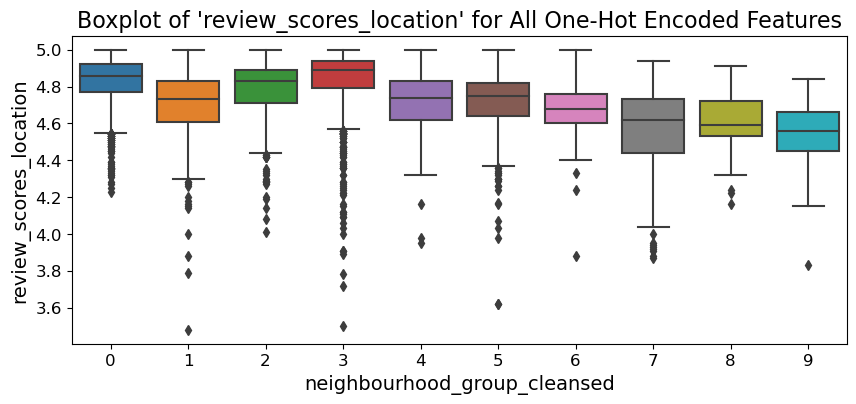

+------------+---------------------+
| Attributes |       Values        |
+------------+---------------------+
|     0      |      Eixample       |
|     1      |     Sant Martí      |
|     2      |       Gràcia        |
|     3      |    Ciutat Vella     |
|     4      | Sarrià-Sant Gervasi |
|     5      |   Sants-Montjuïc    |
|     6      |      Les Corts      |
|     7      |   Horta-Guinardó    |
|     8      |     Sant Andreu     |
|     9      |     Nou Barris      |
+------------+---------------------+

In [50]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='neighbourhood_group_cleansed', y='review_scores_location', data=insights)
plt.title("Boxplot of 'review_scores_location' for All One-Hot Encoded Features", fontsize=16)

legend_labels = insights['neighbourhood_group_cleansed'].unique()
plt.xticks(range(10), [str(i) for i in range(10)])
plt.show()

from tabulate import tabulate

# Create a DataFrame for the table
table_data = {'Attributes': range(10), 'Values': [legend_labels[i] for i in range(10)]}
df_table = pd.DataFrame(table_data)

# Print the DataFrame as a nice table
table = tabulate(df_table, headers='keys', tablefmt='pretty', showindex=False)
print(table)

In [51]:
feature_stats_df = insights.groupby('neighbourhood_group_cleansed')['review_scores_location'].describe()
display(feature_stats_df)
feature_stats_df = insights.groupby('neighbourhood_cleansed')['review_scores_location'].describe()
feature_stats_df = feature_stats_df[feature_stats_df['count'] >= 4]

pd.set_option('display.max_rows', None)
display(feature_stats_df.head(64))
pd.reset_option('display.max_rows')

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Ciutat Vella,937.0,4.829669,0.185532,3.50,4.79,4.89,4.9400,5.00
Eixample,2495.0,4.835587,0.117861,4.23,4.77,4.86,4.9200,5.00
Gràcia,576.0,4.787413,0.154105,4.01,4.71,4.83,4.8900,5.00
Horta-Guinardó,156.0,4.558397,0.245936,3.87,4.44,4.62,4.7325,4.94
Les Corts,95.0,4.661895,0.154206,3.88,4.60,4.68,4.7600,5.00
Nou Barris,41.0,4.533902,0.210534,3.83,4.45,4.56,4.6600,4.84
Sant Andreu,33.0,4.594242,0.190575,4.16,4.53,4.59,4.7200,4.91
Sant Martí,558.0,4.698548,0.178307,3.48,4.61,4.73,4.8300,5.00
Sants-Montjuïc,618.0,4.718511,0.163942,3.62,4.64,4.75,4.8200,5.00


,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
Can Baró,19.0,4.551579,0.190708,4.21,4.3950,4.620,4.6750,4.84
Diagonal Mar i el Front Marítim del Poblenou,53.0,4.724151,0.121425,4.39,4.6700,4.730,4.8100,4.93
Horta,4.0,4.585000,0.169214,4.38,4.4850,4.600,4.7000,4.76
Hostafrancs,61.0,4.790000,0.121915,4.30,4.7300,4.800,4.8700,4.98
Navas,10.0,4.712000,0.165583,4.39,4.6000,4.740,4.8475,4.91
Pedralbes,8.0,4.651250,0.211149,4.33,4.4675,4.750,4.8050,4.87
Porta,6.0,4.603333,0.123558,4.47,4.5100,4.575,4.7000,4.77
Provençals del Poblenou,22.0,4.617727,0.235532,3.79,4.6025,4.660,4.7400,4.88
Sant Andreu,10.0,4.566000,0.161809,4.22,4.5300,4.580,4.6575,4.77


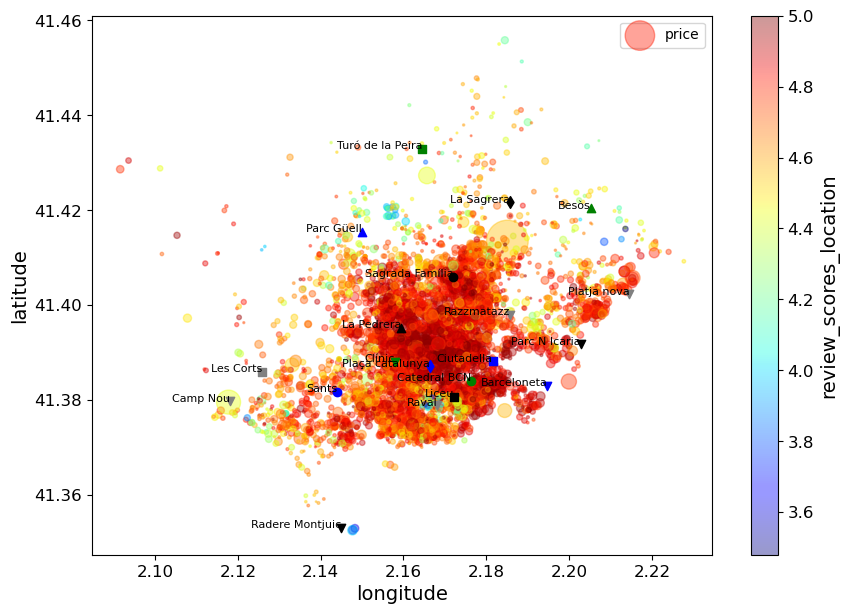

In [52]:


try:
    insights["price"] = insights["price"].apply(lambda x: float(x.replace("$", "").replace(",", "")))
except (AttributeError, ValueError) as e:
    print("Price already transformed to float")


insights.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
              s=insights['price']/10, label='price', figsize=(10,7),
              c="review_scores_location", cmap=plt.get_cmap("jet"), colorbar=True,
              sharex=False)

# Add scatter points for landmarks with different markers and colors
plt.scatter(2.1720037, 41.4060085, c='black', marker='o', label='Sagrada Família')
plt.scatter(2.1593474, 41.3952872, c='black', marker='^', label='La Pedrera')
plt.scatter(2.1723068, 41.380741, c='black', marker='s', label='Liceu')
plt.scatter(2.1857127, 41.421634, c='black', marker='d', label='La Sagrera')
plt.scatter(2.1448975, 41.3531466, c='black', marker='v', label='Radere Montjuic')
plt.scatter(2.1662986, 41.3871498, c='blue', marker='d', label='Plaça catalunya')
plt.scatter(2.1815693, 41.388152, c='blue', marker='s', label='Ciutadella')
plt.scatter(2.1439974, 41.3817246, c='blue', marker='o', label='Sants')
plt.scatter(2.1499003, 41.4155128, c='blue', marker='^', label='Parc Güell')
plt.scatter(2.1947006, 41.382989, c='blue', marker='v', label='Barceloneta')
plt.scatter(2.1580019, 41.3880077, c='green', marker='v', label='Clínic')
plt.scatter(2.1763053, 41.384097, c='green', marker='o', label='Catedral BCN')
plt.scatter(2.205259, 41.4203897, c='green', marker='^', label='Besòs')
plt.scatter(2.1645503, 41.4329238, c='green', marker='s', label='Turó de la Peira')
plt.scatter(2.1258811, 41.3860349, c='grey', marker='s', label='Les Corts')
plt.scatter(2.1857993, 41.3979823, c='grey', marker='v', label='Razzmatazz')
plt.scatter(2.214512,41.402274, c='grey', marker='v', label='Platja nova')
plt.scatter(2.1180945,41.3797289, c='grey', marker='v', label='Camp Nou')
plt.scatter(2.1681625,41.3789204, c='grey', marker='v', label='Raval')
plt.scatter(2.2028073,41.3917361, c='black', marker='v', label='Parc N Icaria')



# Fill in the landmark dictionary with locations and coordinates
landmark_dict = {
    'Sagrada Família': (2.1720037, 41.4060085),
    'La Pedrera': (2.1593474, 41.3952872),
    'Liceu': (2.1723068, 41.380741),
    'La Sagrera': (2.1857127, 41.421634),
    'Radere Montjuic': (2.1448975, 41.3531466),
    'Plaça catalunya': (2.1662986, 41.3871498),
    'Ciutadella': (2.1815693, 41.388152),
    'Sants': (2.1439974, 41.3817246),
    'Parc Güell': (2.1499003, 41.4155128),
    'Barceloneta': (2.1947006, 41.382989),
    'Clínic': (2.1580019, 41.3880077),
    'Catedral BCN': (2.1763053, 41.384097),
    'Besòs': (2.205259, 41.4203897),
    'Turó de la Peira': (2.1645503, 41.4329238),
    'Les Corts': (2.1258811, 41.3860349),
    'Razzmatazz': (2.1857993, 41.3979823),
    'Platja nova': (2.214512,41.402274),
    'Camp Nou': (2.1180945,41.3797289),
    'Raval': (2.1681625,41.3789204),
    'Parc N Icaria': (2.2028073,41.3917361)
}

# Add labels for landmarks
for landmark, (lon, lat) in landmark_dict.items():
    plt.text(lon, lat, landmark, fontsize=8, ha='right')

#plt.legend()
#plt.savefig("images/location_map.png")
plt.show()


### Create new features

In [53]:
def euclidean_distance(lon1, lat1, lon2, lat2):
    return np.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)

for landmark, (lon, lat) in landmark_dict.items():
    column_name = f'Eucld_{landmark}'
    insights[column_name] = euclidean_distance(insights['longitude'], insights['latitude'], lon, lat)

#print(insights.head())

insights.to_csv("bdd_barcelona/insight_with_sentiment_GPT_Landmark.csv",index=False)


### Predicting Location score

In [54]:
# Encoding Neibourhood
def easy_encode_location(bdd, aditional_columns,B_columns = 'review_scores_location'):
    nei_list = ['neighbourhood_group_cleansed','neighbourhood_cleansed',"property_type","room_type"]

    # Tranformer
    nei_pipeline = ColumnTransformer([
        ('nei',OneHotEncoder(), nei_list),
    ])

    nei_pipeline.fit(bdd)
    A = pd.DataFrame(nei_pipeline.transform(bdd).toarray(), columns = nei_pipeline.get_feature_names_out())

    try:
        A[aditional_columns] = bdd[aditional_columns]
    except:
        pass
    B = bdd[B_columns].copy()
    return (A,B)


In [55]:
def train_model_simple(A,B,results_df,name):
    print("-------------- MODEL TRAINING: START ----------------------------")
    A.fillna(A.mean(), inplace=True)
    B.fillna(B.mean(), inplace=True)
    # Split the dataset into training and test sets (e.g., 80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)


    model = RandomForestRegressor(n_estimators=100,random_state=0)

    model.fit(X_train, y_train)

    # Save the trained model to a file
    with open(fr'models/location/random_forest_model_{name}.pkl', 'wb') as file:
        pickle.dump(model, file)

    print("-------------- MODEL TRAINING: FINISH ----------------------------")
    y_pred_rf = model.predict(X_test)

    table = PrettyTable()
    table.field_names = ["Model", "Score type", "R^2", "MSE"]

    mse = mean_squared_error(y_test.values.T, y_pred_rf.T)
    r2 = r2_score(y_test.values.T, y_pred_rf.T)
    table.add_row([f"RF >{name}", "Location", f"{r2:.4f}", f"{mse:.4f}"])
    print(table)
    rows_to_append = []
    rows_to_append.append({"Model": name,
                               "Score type": 'location',
                               "R^2": r2,
                               "MSE": mse})
    return pd.concat([results_df, pd.DataFrame(rows_to_append)], ignore_index=True, axis = 0),model


In [56]:
def location_easy_train():
    values_to_check = ['average_value_per_listing_id','host_listings_count']
    results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
    model_dict = {}
    eucl_list = []
    for i in list(landmark_dict.keys()):
        eucl_list.append(f"Eucld_{i}")

    A_euc = insights[eucl_list].copy()
    A,B = easy_encode_location(insights, values_to_check)
    A_final = pd.concat([A,A_euc],axis = 1)
    results_df,model = train_model_simple(A_final,B,results_df,values_to_check)
    model_dict[i] = model
    display(results_df)
location_easy_train()

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------------------------------------------------------+------------+--------+--------+
|                            Model                            | Score type |  R^2   |  MSE   |
+-------------------------------------------------------------+------------+--------+--------+
| RF >['average_value_per_listing_id', 'host_listings_count'] |  Location  | 0.6434 | 0.0105 |
+-------------------------------------------------------------+------------+--------+--------+

,Model,Score type,R^2,MSE
0,"[average_value_per_listing_id, host_listings_count]",location,0.643356,0.01051


In [57]:
values_to_check = ['average_value_per_listing_id','host_listings_count',['average_value_per_listing_id','host_listings_count'],""]
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
model_dict = {}
eucl_list = []
for i in list(landmark_dict.keys()):
    eucl_list.append(f"Eucld_{i}")

A_euc = insights[eucl_list].copy()
B = insights['review_scores_location'].copy()
results_df,model = train_model_simple(A_euc,B,results_df,"landmark")
model_dict["Landmark"] = model
for i in range(len(values_to_check)):
    A,B = easy_encode_location(insights, values_to_check[i])
    A_final = pd.concat([A,A_euc],axis = 1)
    results_df,model = train_model_simple(A_final,B,results_df,values_to_check[i])
    model_dict[i] = model
display(results_df)

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+--------------+------------+--------+--------+
|    Model     | Score type |  R^2   |  MSE   |
+--------------+------------+--------+--------+
| RF >landmark |  Location  | 0.4357 | 0.0166 |
+--------------+------------+--------+--------+

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+----------------------------------+------------+--------+--------+
|              Model               | Score type |  R^2   |  MSE   |
+----------------------------------+------------+--------+--------+
| RF >average_value_per_listing_id |  Location  | 0.6146 | 0.0114 |
+----------------------------------+------------+--------+--------+

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------------------+------------+--------+--------+
|          Model          | Score type |  R^2   |  MSE   |
+-------------------------+------------+--------+--------+
| RF >host_listings_count |  Location  | 0.5766 | 0.0125 |
+-------------------------+------------+--------+--------+

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------------------------------------------------------+------------+--------+--------+
|                            Model                            | Score type |  R^2   |  MSE   |
+-------------------------------------------------------------+------------+--------+--------+
| RF >['average_value_per_listing_id', 'host_listings_count'] |  Location  | 0.6434 | 0.0105 |
+-------------------------------------------------------------+------------+--------+--------+

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------+------------+--------+--------+
| Model | Score type |  R^2   |  MSE   |
+-------+------------+--------+--------+
|  RF > |  Location  | 0.4973 | 0.0148 |
+-------+------------+--------+--------+

,Model,Score type,R^2,MSE
0,landmark,location,0.435663,0.016631
1,average_value_per_listing_id,location,0.614629,0.011357
2,host_listings_count,location,0.576604,0.012477
3,"[average_value_per_listing_id, host_listings_count]",location,0.643356,0.010510
4,,location,0.497297,0.014814


In [58]:
filtered_insights["bathrooms_text"].str.extract(r'(\d+(\.\d+)?)', expand=False)[0].astype(float)

0       2.0
1       2.0
2       1.5
3       2.0
4       3.0
       ... 
5673    1.0
5674    2.0
5675    1.0
5676    1.0
5677    1.0
Name: 0, Length: 5678, dtype: float64

In [59]:
outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]

#A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
#A_final = pd.concat([A,A_euc],axis = 1)
#results_df = model_testing(A_final,B,"landmarks") 
eucl_list = []
for i in list(landmark_dict.keys()):
    eucl_list.append(f"Eucld_{i}")

A_euc = insights[eucl_list].copy()

A,B = bdd_premodel(filtered_insights,recalculate = True)
A_final = pd.concat([A,A_euc],axis = 1)
results_df = model_testing(A_final,B,"full_plus_land",results_df) 

outpus_types = 'review_scores_location'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_location")

"""outpus_types = 'review_scores_rating'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_rating")

outpus_types = 'review_scores_accuracy'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_accuracy")

outpus_types = 'review_scores_cleanliness'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_cleanliness")

outpus_types = 'review_scores_checkin'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_checkin")

outpus_types = 'review_scores_communication'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_communication")

outpus_types = 'review_scores_location'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_location")

A,B = bdd_premodel(filtered_insights)
B = insights['review_scores_location'].copy()
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"full_plus_lan_location")

outpus_types = 'review_scores_value'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_value")"""



display(results_df)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

Shape of A before transforming: (5678, 103)

Price already transformed to float

Shape of A after full transforming: (5678, 318)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------------------+-----------------------------+--------+--------+
|         Model          |          Score type         |  R^2   |  MSE   |
+------------------------+-----------------------------+--------+--------+
| RF >full_plus_landrevi |     review_scores_rating    | 0.5201 | 0.0268 |
| RF >full_plus_landrevi |    review_scores_accuracy   | 0.4722 | 0.0234 |
| RF >full_plus_landrevi |  review_scores_cleanliness  | 0.3980 | 0.0382 |
| RF >full_plus_landrevi |    review_scores_checkin    | 0.6207 | 0.0175 |
| RF >full_plus_landrevi | review_scores_communication | 0.5110 | 0.0187 |
| RF >full_plus_landrevi |    review_scores_location   | 0.5645 | 0.0128 |
| RF >full_plus_landrevi |     review_scores_value     | 0.5159 | 0.0279 |
+------------------------+-----------------------------+--------+--------+

3.602335302779349

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------------+------------+--------+--------+
|      Model       | Score type |  R^2   |  MSE   |
+------------------+------------+--------+--------+
| RF >lan_location |  Location  | 0.6434 | 0.0105 |
+------------------+------------+--------+--------+

,Model,Score type,R^2,MSE
0,landmark,location,0.435663,0.016631
1,average_value_per_listing_id,location,0.614629,0.011357
2,host_listings_count,location,0.576604,0.012477
3,"[average_value_per_listing_id, host_listings_count]",location,0.643356,0.010510
4,,location,0.497297,0.014814
5,RF >full_plus_landrevi,review_scores_rating,0.520096,0.026763
6,RF >full_plus_landrevi,review_scores_accuracy,0.472152,0.023367
7,RF >full_plus_landrevi,review_scores_cleanliness,0.398044,0.038196
8,RF >full_plus_landrevi,review_scores_checkin,0.620695,0.017508
9,RF >full_plus_landrevi,review_scores_communication,0.510967,0.018660


El millor resultat de localització s'ha assolit utilitzant només utilitzant els següents atributs:
- average_value_per_listing_id
- host_listings_count
- All features that contain the Euclid distance to the Landmarks
- The One-Hot Encoding of: 'neighbourhood_group_cleansed','neighbourhood_cleansed',"property_type","room_type"

In [60]:
values_to_check = ['average_value_per_listing_id','host_listings_count',['average_value_per_listing_id','host_listings_count'],""]
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
model_dict = {}
eucl_list = []
for i in list(landmark_dict.keys()):
    eucl_list.append(f"Eucld_{i}")

A_euc = insights[eucl_list].copy()

outpus_types = 'review_scores_location'
A,B = easy_encode_location(insights, ['average_value_per_listing_id','host_listings_count'],outpus_types)
A_final = pd.concat([A,A_euc],axis = 1)
results_df,model = train_model_simple(A_final,B,results_df,"lan_location")

# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A_final, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)


-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------------+------------+--------+--------+
|      Model       | Score type |  R^2   |  MSE   |
+------------------+------------+--------+--------+
| RF >lan_location |  Location  | 0.6434 | 0.0105 |
+------------------+------------+--------+--------+

In [61]:
y_train.values

array([4.72, 4.93, 4.76, ..., 4.93, 4.92, 4.8 ])

Location

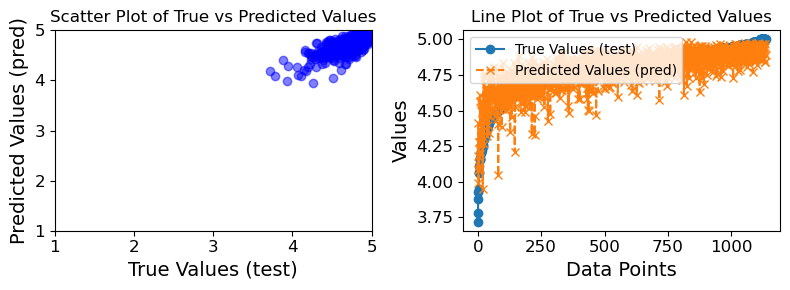

In [62]:
print(f"Location")
visualise_outcom(y_test.values.T, y_pred_rf.T)

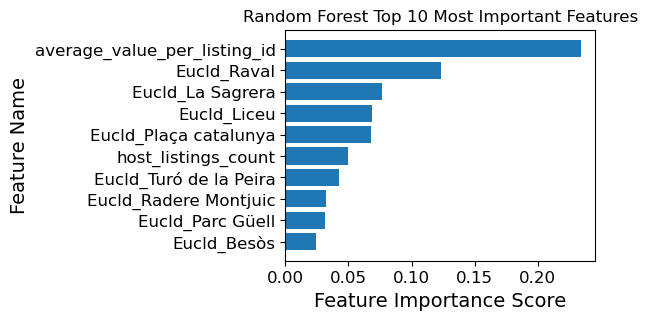

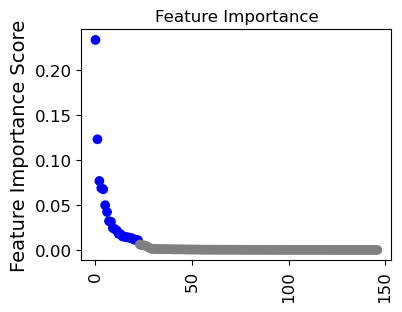

In [63]:
data = {'Name': X_train.columns, 'Score': model.feature_importances_}
df = pd.DataFrame(data)
df = df.sort_values(by='Score', ascending=False)
top_10 = df.head(10)

# Plot a bar chart for the top 10 features
plt.figure(figsize=(4, 3))
plt.barh(top_10['Name'], top_10['Score'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.title('Random Forest Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()

x = [i for i in range(len(df['Score']))]
colors = ['grey' if score < 0.009 else 'blue' for score in df['Score']]
plt.figure(figsize=(4, 3))
plt.scatter(x, df['Score'], c=colors, marker='o')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance')
plt.xticks( rotation=90)  # Set x-axis labels and rotate for better readability
plt.show()

## Missing values

In [64]:
# Lets look into the missing values in the score variables
outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
results = {}
insights_2 = pd.read_csv('bdd_barcelona/insight_with_sentiment_GPT_Landmark.csv')
filtered_insights_25 = filter_accomodation_num_review(insights_2, 'number_of_reviews', 25)

In [65]:
results = {}
total = len(filtered_insights_25.index)
for i in outpus_types:
    results[i] = filtered_insights_25[i].isnull().sum()/total

    
missing_values_per_row = filtered_insights_25.isnull().sum(axis=1)
rows_with_more_than_4_missing_values = filtered_insights_25[missing_values_per_row > 5]
print("-------------------------Missing values in rows------------------------------------")
print(f"The percentage of accomodations with at least 5 missing values is: {len(rows_with_more_than_4_missing_values)/len(filtered_insights_25)}, therefore I cannot just delete all rows with at least 5 missings. We will treat each atribute differently")

print("-------------------------Percentage of missing values per review score------------------------------------")
display(results)
results = {}
print("As we can see from the previouse dictionary, there are no missing values on any of the review scores for the accomodations that have over 25 reviews/accomodation. This is very good.")
for i in list(filtered_insights_25.columns):
    value = filtered_insights_25[i].isnull().sum()/total * 100
    if value != 0:
        results[i] = value.__round__(2)

sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

print("-------------------------Percentage of missing values per feature------------------------------------")
print("We are only going to be printing the ones with non 0 amound")
display(sorted_results)
print("""We don't have a lot of missing data, yet it is not uniform across all columns and rows. This means that we need to use different approaches for every scenario, we can extract a few things from this experiment:
      - 'calendar_updated' can be deleted since they dont have any meaningfull value.
      - 'bathrooms' will be filled with the data from bathroom_text wich contains all the information neaded
      - The ones that have upwards of 20% of missing values, could be repaced with a boolean variable saying missing or not.
        - Afer further investigation, all ot these missing values are evenly distributed when looking at all of the score metrics.
      - The ones that are below 1% can be just set to the average or delete the hole row, I will chose the average method.
      - For the ones that are close to 10% I will just set to the average.
""")

-------------------------Missing values in rows------------------------------------

The percentage of accomodations with at least 5 missing values is: 0.23089115885875308, therefore I cannot just 
delete all rows with at least 5 missings. We will treat each atribute differently

-------------------------Percentage of missing values per review score------------------------------------

{'review_scores_rating': 0.0,
 'review_scores_accuracy': 0.0,
 'review_scores_cleanliness': 0.0,
 'review_scores_checkin': 0.0,
 'review_scores_communication': 0.0,
 'review_scores_location': 0.0,
 'review_scores_value': 0.0}

As we can see from the previouse dictionary, there are no missing values on any of the review scores for the 
accomodations that have over 25 reviews/accomodation. This is very good.

-------------------------Percentage of missing values per feature------------------------------------

We are only going to be printing the ones with non 0 amound

{'bathrooms': 100.0,
 'calendar_updated': 100.0,
 'host_neighbourhood': 28.97,
 'neighborhood_overview': 27.77,
 'neighbourhood': 27.77,
 'bedrooms': 25.04,
 'license': 23.48,
 'host_is_superhost': 23.12,
 'host_about': 22.86,
 'host_location': 14.56,
 'host_response_time': 8.82,
 'host_response_rate': 8.82,
 'host_acceptance_rate': 6.97,
 'beds': 0.79,
 'bathrooms_text': 0.09,
 'description': 0.02}

We don't have a lot of missing data, yet it is not uniform across all columns and rows. This means that we need to 
use different approaches for every scenario, we can extract a few things from this experiment:
      - 'calendar_updated' can be deleted since they dont have any meaningfull value.
      - 'bathrooms' will be filled with the data from bathroom_text wich contains all the information neaded
      - The ones that have upwards of 20% of missing values, could be repaced with a boolean variable saying 
missing or not.
        - Afer further investigation, all ot these missing values are evenly distributed when looking at all of the
score metrics.
      - The ones that are below 1% can be just set to the average or delete the hole row, I will chose the average 
method.
      - For the ones that are close to 10% I will just set to the average.

In [66]:
# 6-----------------------------------FORMAT bathrooms_text--------------------------------------------------

#filtered_insights_25["bathrooms"] = filtered_insights_25["bathrooms_text"].str.extract(r'(\d+(\.\d+)?)', expand=False)[0].astype(float)
#print(filtered_insights_25["bathrooms"])
#per = filtered_insights_25["bathrooms"].isnull().sum()/5678
#print(f"In this process, we have only generated {per} new missing values wich is acceptable.")

## Outliers

In [67]:
outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
results = {}
insights_2 = pd.read_csv('bdd_barcelona/insight_with_sentiment_GPT_Landmark.csv')
filtered_insights = filter_accomodation_num_review(insights_2, 'number_of_reviews', 25)

In [68]:
print("""We will study the 5 accomodations with higher and lower reviwe scores in the 7 different categories and try to extract some patterns or some valuable information to improve our chance to find patterns""")

outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
results = {}
total = pd.DataFrame()
bad = pd.DataFrame()
good = pd.DataFrame()
for column in outpus_types:
    top_5_high = filtered_insights.nlargest(5, column)
    top_5_low = filtered_insights.nsmallest(5, column)
    #print(f"Top 5 rows with highest values in '{column}':")
    #print(top_5_high)
    #print("\n")
    #print(f"Top 5 rows with lowest values in '{column}':")
    #print(top_5_low)

    results[column] = {"H":top_5_high,"L":top_5_low}
    total = pd.concat([top_5_high,top_5_low,total],axis=0)
    good = pd.concat([top_5_high,good],axis=0)
    bad = pd.concat([top_5_low,bad],axis=0)

print(len(total['id'].unique()))

#display(results['review_scores_rating']["L"])


We will study the 5 accomodations with higher and lower reviwe scores in the 7 different categories and try to 
extract some patterns or some valuable information to improve our chance to find patterns

55

In [69]:
feature_stats_df = bad.groupby('neighbourhood_group_cleansed')['review_scores_location'].describe()
display(feature_stats_df)
feature_stats_df = bad.groupby('neighbourhood_cleansed')['review_scores_location'].describe()
feature_stats_df = feature_stats_df[feature_stats_df['count'] >= 4]

pd.set_option('display.max_rows', None)
display(feature_stats_df.head(64))
pd.reset_option('display.max_rows')

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group_cleansed,,,,,,,,
Ciutat Vella,6.0,3.896667,0.536122,3.50,3.5000,3.610,4.3650,4.58
Eixample,14.0,4.587857,0.195377,4.32,4.4500,4.550,4.7975,4.82
Gràcia,3.0,4.470000,0.158745,4.29,4.4100,4.530,4.5600,4.59
Nou Barris,1.0,4.300000,NaN,4.30,4.3000,4.300,4.3000,4.30
Sant Martí,4.0,4.270000,0.581664,3.48,4.0200,4.405,4.6550,4.79
Sants-Montjuïc,6.0,4.216667,0.467789,3.62,3.8225,4.445,4.5125,4.64
Sarrià-Sant Gervasi,1.0,4.500000,NaN,4.50,4.5000,4.500,4.5000,4.50


,count,mean,std,min,25%,50%,75%,max
neighbourhood_cleansed,,,,,,,,
el Raval,4.0,3.555,0.110000,3.50,3.50,3.50,3.555,3.72
l'Antiga Esquerra de l'Eixample,5.0,4.802,0.010954,4.79,4.80,4.80,4.800,4.82
la Dreta de l'Eixample,4.0,4.450,0.000000,4.45,4.45,4.45,4.450,4.45


review_scores_rating           1.000000
review_scores_accuracy         0.917143
review_scores_value            0.913943
review_scores_cleanliness      0.838268
review_scores_communication    0.797940
review_scores_checkin          0.757434
review_scores_location         0.514725
Name: review_scores_rating, dtype: float64

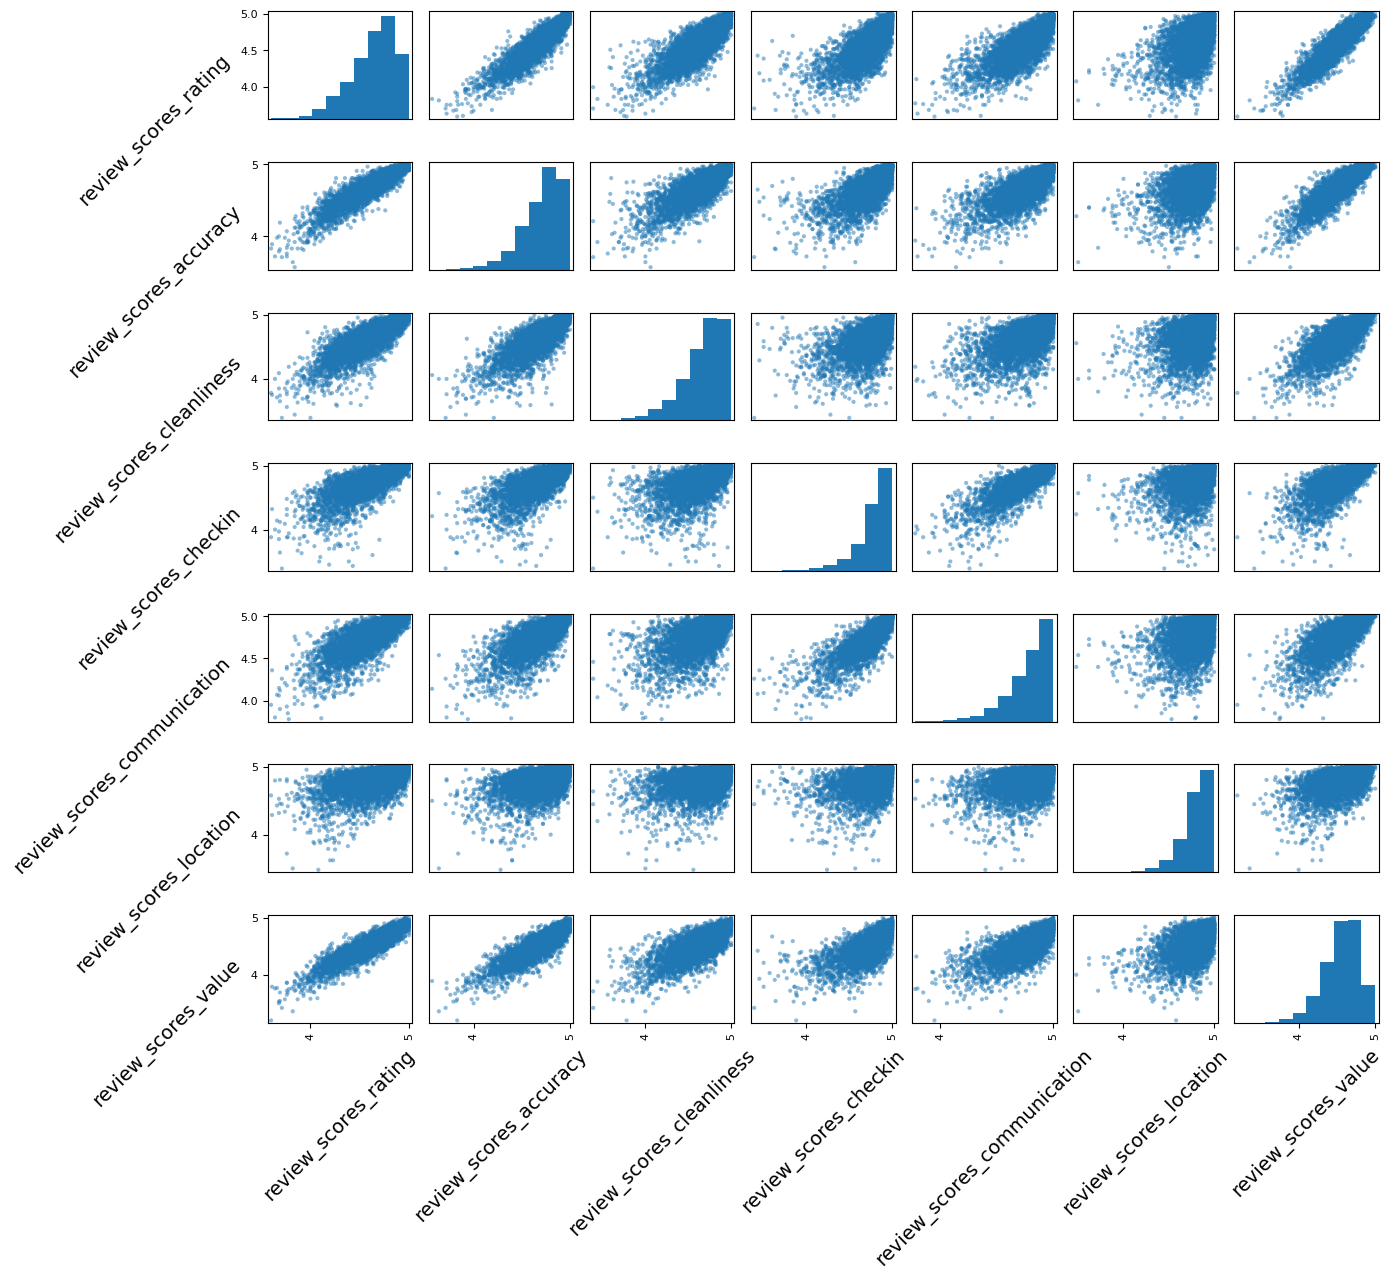

In [70]:
import pandas.plotting as pd_plotting
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

attributes = outpus_types.copy()
#attributes.append('average_value_per_listing_id')
#attributes.append('host_listings_count')
corr_matrix = filtered_insights_25[attributes].corr()
corr_matrix["review_scores_rating"].sort_values(ascending=False)
display(corr_matrix["review_scores_rating"].sort_values(ascending=False))
#scatter_matrix(filtered_insights_25[attributes], figsize=(17, 15), diagonal='hist',)
#save_fig("scatter_matrix_plot")

scatter_matrix_plot = pd_plotting.scatter_matrix(filtered_insights_25[attributes], figsize=(14, 13), diagonal='hist')
for ax in scatter_matrix_plot.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.savefig("images/score_correlations.png")
plt.show()


From this, we can extract that the three most positively coorelated scores to the global score are: accuracy, value and cleanness. That means that one has to tell the truth, give a good price and keep the accomodation clean. We can also see that the location is the least coorrelated of the scores to the global score wich is very interesting and nice to know if you already have an accomodation, because it means that you can do things to improve your valuation.

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

review_scores_rating          1.000000
host_is_superhost             0.447795
Extra pillows and blankets    0.270498
soap                          0.227851
parking                       0.217668
First aid kit                 0.214844
Room-darkening shades         0.214027
Carbon monoxide alarm         0.208656
number_of_reviews             0.204902
books                         0.202167
Host greets you               0.194115
Smoke alarm                   0.190924
Luggage dropoff allowed       0.186546
Wine glasses                  0.175850
Hangers                       0.175198
shampoo                       0.171999
Fire extinguisher             0.157671
Baby                          0.155751
Hot water                     0.155532
Private patio or balcony      0.151244
chair                         0.143861
Laundromat nearby             0.137547
Cooking basics                0.132157
Dedicated workspace           0.128452
Dining table                  0.126978
Name: review_scores_ratin

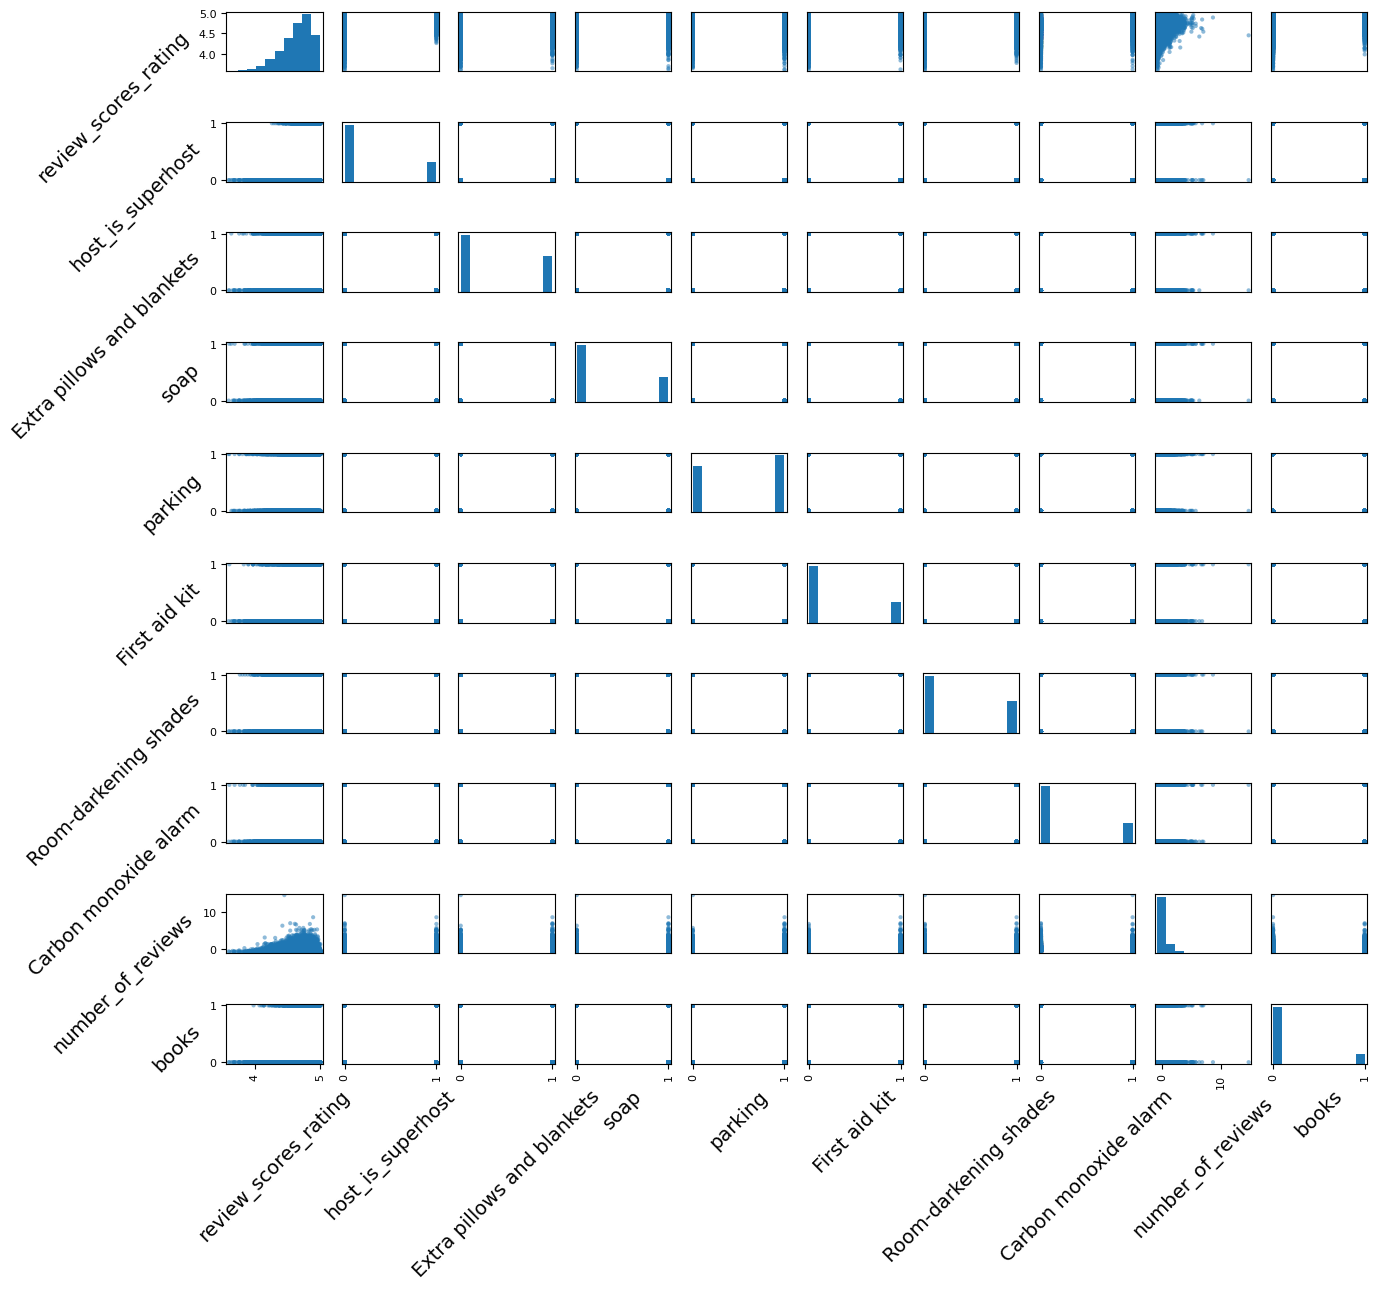

In [71]:
values_to_check = ['average_value_per_listing_id','host_listings_count',['average_value_per_listing_id','host_listings_count'],""]
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
model_dict = {}
eucl_list = []
for i in list(landmark_dict.keys()):
    eucl_list.append(f"Eucld_{i}")

A_euc = insights[eucl_list].copy()

A,B = bdd_premodel(filtered_insights,recalculate = False)
A_final = pd.concat([A,A_euc,B['review_scores_rating']],axis = 1)
corr_matrix = A_final.corr()
corr_matrix["review_scores_rating"].sort_values(ascending=False)
top_25 = corr_matrix["review_scores_rating"].sort_values(ascending=False).head(25)
display(top_25)

correlated_features = top_25[abs(top_25) > 0.2].index.tolist()

scatter_matrix_plot = pd_plotting.scatter_matrix(A_final[correlated_features], figsize=(14, 13), diagonal='hist')
for ax in scatter_matrix_plot.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.savefig("images/attribute_correlations.png")
plt.show()


In [80]:
def print_atri_corr_2(A_final,corr_features,name = "rating_corr"):
    scatter_matrix_plot = scatter_matrix(A_final[corr_features], figsize=(14, 13), diagonal='hist')

    for i, ax_row in enumerate(scatter_matrix_plot):
        for j, ax in enumerate(ax_row):
            if i != 0:
                ax.set_visible(False)
            else:
                ax.xaxis.label.set_rotation(45)
                ax.yaxis.label.set_rotation(0)
                ax.yaxis.label.set_ha('right')
                ax.get_xaxis().set_visible(True)

    plt.subplots_adjust(wspace=0.1)
    plt.savefig(f"images/{name}2.png")
    plt.show()

def print_all_corr_2(bdd):
    outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
    results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
    eucl_list = []
    for i in list(landmark_dict.keys()):
        eucl_list.append(f"Eucld_{i}")
    A_euc = insights[eucl_list].copy()

    A,B = bdd_premodel(bdd,recalculate = False)

    for i in outpus_types:
        A_final = pd.concat([A,A_euc,B[i]],axis = 1)
        corr_matrix = A_final.corr()
        corr_matrix[i].sort_values(ascending=True)
        top_25 = corr_matrix[i].sort_values(ascending=True).head(11)
        display(top_25)
        correlated_features = top_25[abs(top_25) > 0.2].index.tolist()
        #print_atri_corr_2(A_final,correlated_features,i)
    #display(top_25)

print_all_corr_2(filtered_insights)
    

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

calculated_host_listings_count                -0.359245
calculated_host_listings_count_entire_homes   -0.352690
host_total_listings_count                     -0.337155
host_listings_count                           -0.326597
Smart lock                                    -0.212175
availability_90                               -0.186696
availability_30                               -0.165475
availability_60                               -0.161659
property_type_Entire rental unit              -0.154395
availability_365                              -0.151295
first_review                                  -0.144572
Name: review_scores_rating, dtype: float64

calculated_host_listings_count                -0.332518
calculated_host_listings_count_entire_homes   -0.325237
host_total_listings_count                     -0.313261
host_listings_count                           -0.302967
availability_90                               -0.198902
first_review                                  -0.195729
Smart lock                                    -0.189515
availability_30                               -0.182274
availability_60                               -0.175657
availability_365                              -0.160177
beds                                          -0.149582
Name: review_scores_accuracy, dtype: float64

calculated_host_listings_count                -0.250616
calculated_host_listings_count_entire_homes   -0.246192
host_total_listings_count                     -0.241722
host_listings_count                           -0.226992
Smart lock                                    -0.134311
first_review                                  -0.132527
availability_90                               -0.127662
beds                                          -0.121735
availability_30                               -0.120411
availability_60                               -0.110628
accommodates                                  -0.104863
Name: review_scores_cleanliness, dtype: float64

calculated_host_listings_count                -0.509806
calculated_host_listings_count_entire_homes   -0.500169
host_listings_count                           -0.444356
host_total_listings_count                     -0.439762
Smart lock                                    -0.318640
first_review                                  -0.223450
availability_90                               -0.216169
property_type_Entire rental unit              -0.206673
has_license                                   -0.182007
availability_365                              -0.177071
availability_60                               -0.176335
Name: review_scores_checkin, dtype: float64

calculated_host_listings_count                -0.394602
calculated_host_listings_count_entire_homes   -0.383067
host_total_listings_count                     -0.358970
host_listings_count                           -0.350697
first_review                                  -0.242146
Smart lock                                    -0.227333
availability_90                               -0.207099
availability_60                               -0.176271
availability_30                               -0.170473
Air conditioning                              -0.165358
availability_365                              -0.139180
Name: review_scores_communication, dtype: float64

Eucld_Catedral BCN                 -0.432894
Eucld_Plaça catalunya              -0.431912
Eucld_Ciutadella                   -0.410291
Eucld_Liceu                        -0.397391
Eucld_La Pedrera                   -0.350497
Eucld_Raval                        -0.350484
Eucld_Clínic                       -0.328364
Eucld_Barceloneta                  -0.316939
Eucld_Razzmatazz                   -0.292228
Eucld_Sagrada Família              -0.266382
neighbourhood_cleansed_el Carmel   -0.227089
Name: review_scores_location, dtype: float64

calculated_host_listings_count                -0.376080
calculated_host_listings_count_entire_homes   -0.372502
host_total_listings_count                     -0.362632
host_listings_count                           -0.351327
availability_90                               -0.264156
property_type_Entire rental unit              -0.234622
availability_60                               -0.229561
availability_30                               -0.227742
Smart lock                                    -0.225216
has_license                                   -0.221755
availability_365                              -0.210146
Name: review_scores_value, dtype: float64

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

review_scores_location                                          1.000000
neighbourhood_cleansed_la Dreta de l'Eixample                   0.273154
neighbourhood_group_cleansed_Eixample                           0.260270
host_is_superhost                                               0.212574
neighbourhood_cleansed_Sant Pere, Santa Caterina i la Ribera    0.157851
neighbourhood_cleansed_el Barri Gòtic                           0.122624
neighbourhood_group_cleansed_Ciutat Vella                       0.115193
Host greets you                                                 0.115131
number_of_reviews                                               0.112241
books                                                           0.103755
Fire extinguisher                                               0.102584
First aid kit                                                   0.090726
chair                                                           0.085053
Carbon monoxide alarm                              

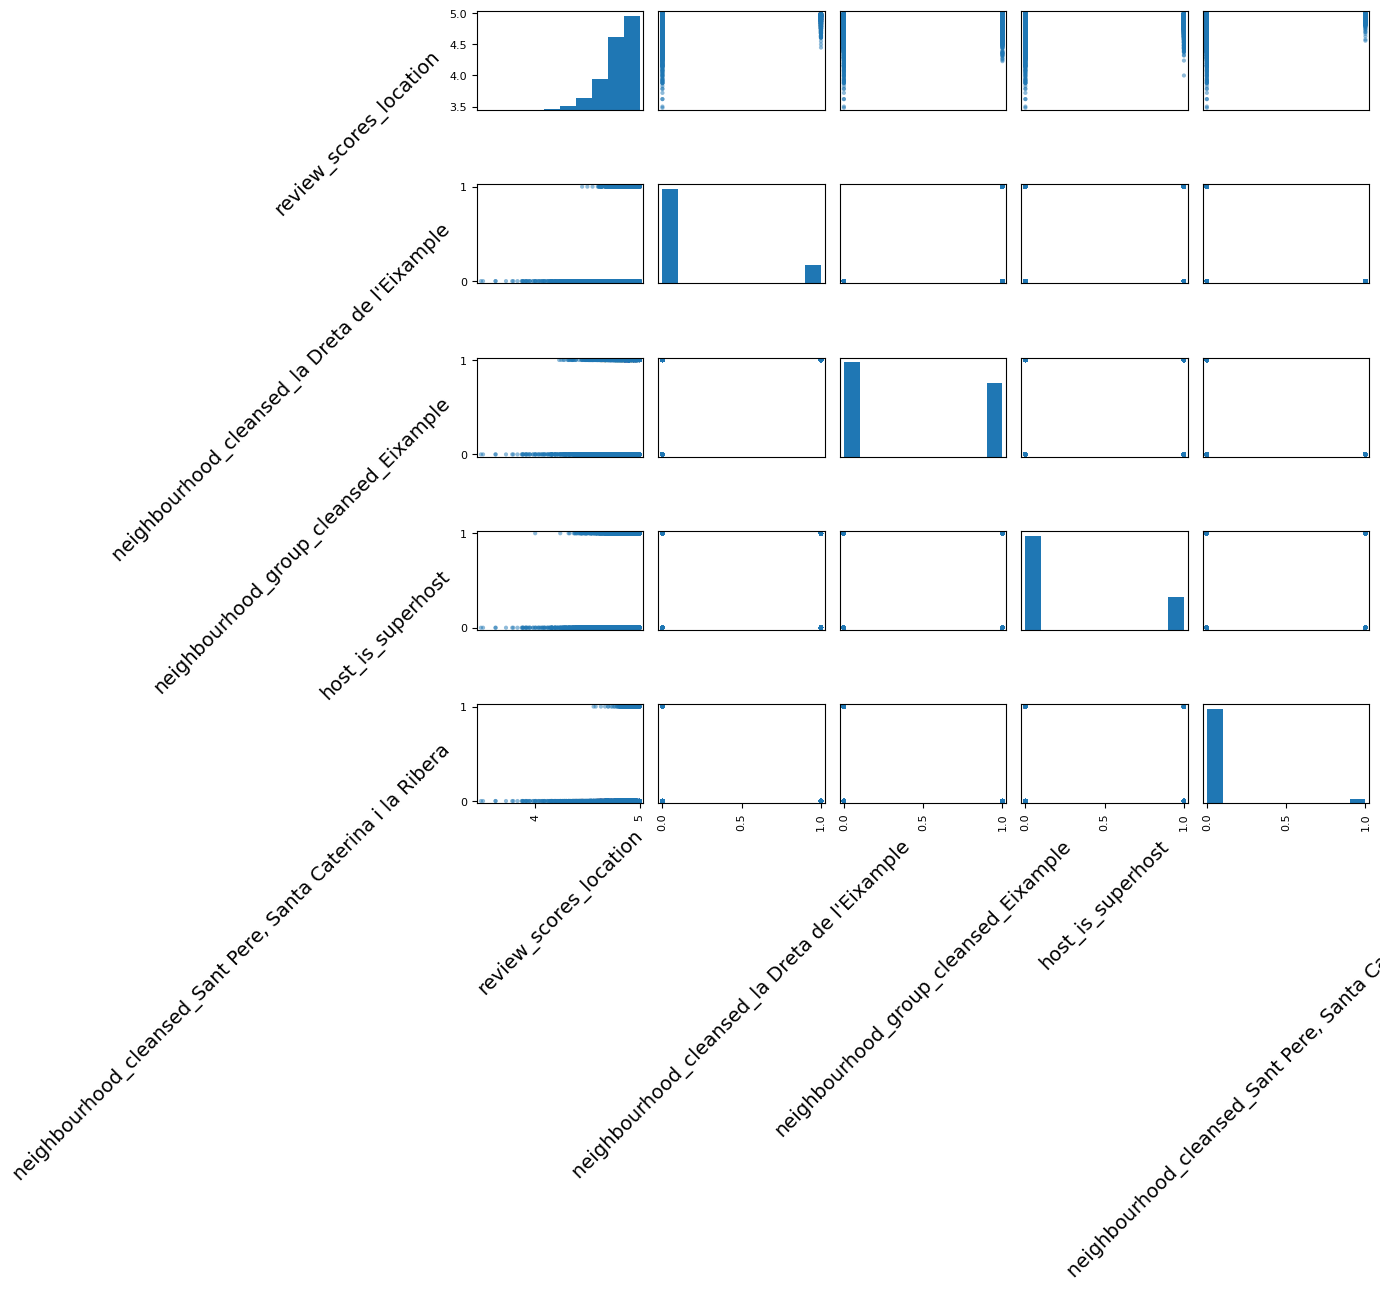

In [79]:
values_to_check = ['average_value_per_listing_id','host_listings_count',['average_value_per_listing_id','host_listings_count'],""]
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
model_dict = {}
eucl_list = []
for i in list(landmark_dict.keys()):
    eucl_list.append(f"Eucld_{i}")

A_euc = insights[eucl_list].copy()

A,B = bdd_premodel(filtered_insights,recalculate = False)
A_final = pd.concat([A,A_euc,B['review_scores_location']],axis = 1)
corr_matrix = A_final.corr()
corr_matrix["review_scores_location"].sort_values(ascending=False)
top_25 = corr_matrix["review_scores_location"].sort_values(ascending=False).head(25)
display(top_25)

correlated_features = top_25[abs(top_25) > 0.15].index.tolist()

scatter_matrix_plot = pd_plotting.scatter_matrix(A_final[correlated_features], figsize=(14, 13), diagonal='hist')
for ax in scatter_matrix_plot.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    
plt.tight_layout()
plt.savefig("images/attribute_correlations.png")
plt.show()